In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.01,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 11:46 - loss: 0.0492 - STD: 2.0571e-04 - MAE: 0.2137

 12/632 [..............................] - ETA: 3s - loss: 0.0762 - STD: 1.7145e-05 - MAE: 0.2517   

 22/632 [>.............................] - ETA: 3s - loss: 0.0769 - STD: 9.3517e-06 - MAE: 0.2530

 32/632 [>.............................] - ETA: 3s - loss: 0.0774 - STD: 6.4293e-06 - MAE: 0.2537

 43/632 [=>............................] - ETA: 2s - loss: 0.0773 - STD: 4.7846e-06 - MAE: 0.2537

 55/632 [=>............................] - ETA: 2s - loss: 0.0774 - STD: 3.7407e-06 - MAE: 0.2540

 67/632 [==>...........................] - ETA: 2s - loss: 0.0774 - STD: 3.0707e-06 - MAE: 0.2539

 78/632 [==>...........................] - ETA: 2s - loss: 0.0773 - STD: 2.6377e-06 - MAE: 0.2539

 88/632 [===>..........................] - ETA: 2s - loss: 0.0772 - STD: 2.3379e-06 - MAE: 0.2539

 98/632 [===>..........................] - ETA: 2s - loss: 0.0771 - STD: 2.0994e-06 - MAE: 0.2537

108/632 [====>.........................] - ETA: 2s - loss: 0.0772 - STD: 1.9050e-06 - MAE: 0.2538

118/632 [====>.........................] - ETA: 2s - loss: 0.0773 - STD: 1.7435e-06 - MAE: 0.2540

128/632 [=====>........................] - ETA: 2s - loss: 0.0773 - STD: 1.6073e-06 - MAE: 0.2539

138/632 [=====>........................] - ETA: 2s - loss: 0.0773 - STD: 1.4909e-06 - MAE: 0.2540

147/632 [=====>........................] - ETA: 2s - loss: 0.0774 - STD: 1.3996e-06 - MAE: 0.2541

157/632 [======>.......................] - ETA: 2s - loss: 0.0774 - STD: 1.3104e-06 - MAE: 0.2541

167/632 [======>.......................] - ETA: 2s - loss: 0.0774 - STD: 1.2320e-06 - MAE: 0.2541

177/632 [=======>......................] - ETA: 2s - loss: 0.0774 - STD: 1.1624e-06 - MAE: 0.2541

187/632 [=======>......................] - ETA: 2s - loss: 0.0774 - STD: 1.1002e-06 - MAE: 0.2541

197/632 [========>.....................] - ETA: 2s - loss: 0.0775 - STD: 1.0444e-06 - MAE: 0.2542

207/632 [========>.....................] - ETA: 2s - loss: 0.0775 - STD: 9.9390e-07 - MAE: 0.2542

218/632 [=========>....................] - ETA: 2s - loss: 0.0774 - STD: 9.4375e-07 - MAE: 0.2541

228/632 [=========>....................] - ETA: 2s - loss: 0.0773 - STD: 9.0236e-07 - MAE: 0.2539

238/632 [==========>...................] - ETA: 1s - loss: 0.0772 - STD: 8.6444e-07 - MAE: 0.2539

248/632 [==========>...................] - ETA: 1s - loss: 0.0772 - STD: 8.2959e-07 - MAE: 0.2538

258/632 [===========>..................] - ETA: 1s - loss: 0.0772 - STD: 7.9743e-07 - MAE: 0.2539

268/632 [===========>..................] - ETA: 1s - loss: 0.0772 - STD: 7.6768e-07 - MAE: 0.2538

278/632 [============>.................] - ETA: 1s - loss: 0.0772 - STD: 7.4006e-07 - MAE: 0.2539

288/632 [============>.................] - ETA: 1s - loss: 0.0772 - STD: 7.1437e-07 - MAE: 0.2539

298/632 [=============>................] - ETA: 1s - loss: 0.0772 - STD: 6.9039e-07 - MAE: 0.2539

309/632 [=============>................] - ETA: 1s - loss: 0.0772 - STD: 6.6582e-07 - MAE: 0.2539

320/632 [==============>...............] - ETA: 1s - loss: 0.0772 - STD: 6.4293e-07 - MAE: 0.2539

330/632 [==============>...............] - ETA: 1s - loss: 0.0772 - STD: 6.2345e-07 - MAE: 0.2539

340/632 [===============>..............] - ETA: 1s - loss: 0.0772 - STD: 6.0511e-07 - MAE: 0.2539

350/632 [===============>..............] - ETA: 1s - loss: 0.0772 - STD: 5.8782e-07 - MAE: 0.2539

360/632 [================>.............] - ETA: 1s - loss: 0.0772 - STD: 5.7149e-07 - MAE: 0.2539

370/632 [================>.............] - ETA: 1s - loss: 0.0772 - STD: 5.5605e-07 - MAE: 0.2539

380/632 [=================>............] - ETA: 1s - loss: 0.0772 - STD: 5.4142e-07 - MAE: 0.2539

390/632 [=================>............] - ETA: 1s - loss: 0.0772 - STD: 5.2753e-07 - MAE: 0.2539

401/632 [==================>...........] - ETA: 1s - loss: 0.0772 - STD: 5.1306e-07 - MAE: 0.2539

412/632 [==================>...........] - ETA: 1s - loss: 0.0772 - STD: 4.9936e-07 - MAE: 0.2539

424/632 [===================>..........] - ETA: 1s - loss: 0.0772 - STD: 4.8523e-07 - MAE: 0.2539

436/632 [===================>..........] - ETA: 0s - loss: 0.0772 - STD: 4.7188e-07 - MAE: 0.2539

446/632 [====================>.........] - ETA: 1s - loss: 0.0772 - STD: 4.6130e-07 - MAE: 0.2539

456/632 [====================>.........] - ETA: 1s - loss: 0.0771 - STD: 4.5119e-07 - MAE: 0.2538

466/632 [=====================>........] - ETA: 1s - loss: 0.0770 - STD: 4.4155e-07 - MAE: 0.2536

476/632 [=====================>........] - ETA: 0s - loss: 0.0761 - STD: 4.3281e-07 - MAE: 0.2512

487/632 [======================>.......] - ETA: 0s - loss: 0.0748 - STD: 4.2367e-07 - MAE: 0.2479

497/632 [======================>.......] - ETA: 0s - loss: 0.0736 - STD: 4.1575e-07 - MAE: 0.2445

507/632 [=======================>......] - ETA: 0s - loss: 0.0724 - STD: 4.0822e-07 - MAE: 0.2411

517/632 [=======================>......] - ETA: 0s - loss: 0.0713 - STD: 4.0073e-07 - MAE: 0.2377

527/632 [========================>.....] - ETA: 0s - loss: 0.0702 - STD: 3.9361e-07 - MAE: 0.2346

537/632 [========================>.....] - ETA: 0s - loss: 0.0691 - STD: 3.8672e-07 - MAE: 0.2315

547/632 [========================>.....] - ETA: 0s - loss: 0.0681 - STD: 3.8025e-07 - MAE: 0.2285

557/632 [=========================>....] - ETA: 0s - loss: 0.0671 - STD: 3.7385e-07 - MAE: 0.2257

567/632 [=========================>....] - ETA: 0s - loss: 0.0661 - STD: 3.6789e-07 - MAE: 0.2229

577/632 [==========================>...] - ETA: 0s - loss: 0.0652 - STD: 3.6187e-07 - MAE: 0.2203

588/632 [==========================>...] - ETA: 0s - loss: 0.0642 - STD: 3.5564e-07 - MAE: 0.2175

600/632 [===========================>..] - ETA: 0s - loss: 0.0632 - STD: 3.4910e-07 - MAE: 0.2145

612/632 [============================>.] - ETA: 0s - loss: 0.0621 - STD: 3.4293e-07 - MAE: 0.2117

624/632 [============================>.] - ETA: 0s - loss: 0.0612 - STD: 3.3674e-07 - MAE: 0.2089

632/632 [==============================] - 6s 7ms/step - loss: 0.0606 - STD: 3.3265e-07 - MAE: 0.2072 - val_loss: 0.0168 - val_STD: 2.9802e-08 - val_MAE: 0.0807


Epoch 2/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0105 - STD: 2.9802e-08 - MAE: 0.0657

 12/632 [..............................] - ETA: 2s - loss: 0.0121 - STD: 2.9802e-08 - MAE: 0.0681 

 24/632 [>.............................] - ETA: 2s - loss: 0.0123 - STD: 3.2286e-08 - MAE: 0.0688

 36/632 [>.............................] - ETA: 2s - loss: 0.0125 - STD: 3.1044e-08 - MAE: 0.0695

 48/632 [=>............................] - ETA: 2s - loss: 0.0125 - STD: 2.9802e-08 - MAE: 0.0696

 60/632 [=>............................] - ETA: 2s - loss: 0.0125 - STD: 2.9802e-08 - MAE: 0.0692

 72/632 [==>...........................] - ETA: 2s - loss: 0.0125 - STD: 2.9181e-08 - MAE: 0.0694

 84/632 [==>...........................] - ETA: 2s - loss: 0.0125 - STD: 2.8561e-08 - MAE: 0.0694

 96/632 [===>..........................] - ETA: 2s - loss: 0.0125 - STD: 2.9337e-08 - MAE: 0.0696

108/632 [====>.........................] - ETA: 2s - loss: 0.0126 - STD: 2.9250e-08 - MAE: 0.0696

120/632 [====>.........................] - ETA: 2s - loss: 0.0126 - STD: 2.8933e-08 - MAE: 0.0699

132/632 [=====>........................] - ETA: 2s - loss: 0.0126 - STD: 2.9125e-08 - MAE: 0.0700

144/632 [=====>........................] - ETA: 2s - loss: 0.0127 - STD: 2.8664e-08 - MAE: 0.0700

156/632 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 2.7987e-08 - MAE: 0.0701

168/632 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 2.7851e-08 - MAE: 0.0700

180/632 [=======>......................] - ETA: 1s - loss: 0.0127 - STD: 2.7816e-08 - MAE: 0.0699

192/632 [========>.....................] - ETA: 1s - loss: 0.0127 - STD: 2.8095e-08 - MAE: 0.0699

204/632 [========>.....................] - ETA: 1s - loss: 0.0126 - STD: 2.7976e-08 - MAE: 0.0698

216/632 [=========>....................] - ETA: 1s - loss: 0.0127 - STD: 2.8216e-08 - MAE: 0.0699

227/632 [=========>....................] - ETA: 1s - loss: 0.0127 - STD: 2.8424e-08 - MAE: 0.0699

238/632 [==========>...................] - ETA: 1s - loss: 0.0127 - STD: 2.8926e-08 - MAE: 0.0699

249/632 [==========>...................] - ETA: 1s - loss: 0.0127 - STD: 2.9144e-08 - MAE: 0.0700

261/632 [===========>..................] - ETA: 1s - loss: 0.0127 - STD: 2.9003e-08 - MAE: 0.0701

272/632 [===========>..................] - ETA: 1s - loss: 0.0127 - STD: 2.9200e-08 - MAE: 0.0700

282/632 [============>.................] - ETA: 1s - loss: 0.0127 - STD: 2.9221e-08 - MAE: 0.0701

293/632 [============>.................] - ETA: 1s - loss: 0.0127 - STD: 2.9192e-08 - MAE: 0.0702

304/632 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 2.9116e-08 - MAE: 0.0702

314/632 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 2.9423e-08 - MAE: 0.0702

324/632 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 2.9112e-08 - MAE: 0.0702

334/632 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 2.9133e-08 - MAE: 0.0702

345/632 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 2.9327e-08 - MAE: 0.0702

355/632 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 2.8921e-08 - MAE: 0.0702

365/632 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 2.9067e-08 - MAE: 0.0703

376/632 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 2.9010e-08 - MAE: 0.0703

387/632 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 2.9225e-08 - MAE: 0.0703

398/632 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 2.9353e-08 - MAE: 0.0703

408/632 [==================>...........] - ETA: 1s - loss: 0.0128 - STD: 2.9181e-08 - MAE: 0.0703

418/632 [==================>...........] - ETA: 0s - loss: 0.0128 - STD: 2.9375e-08 - MAE: 0.0704

428/632 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 2.9733e-08 - MAE: 0.0703

438/632 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 2.9734e-08 - MAE: 0.0703

448/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.9636e-08 - MAE: 0.0703

460/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.9543e-08 - MAE: 0.0703

472/632 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.9771e-08 - MAE: 0.0703

484/632 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.9556e-08 - MAE: 0.0703

496/632 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 2.9262e-08 - MAE: 0.0702

508/632 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 2.9186e-08 - MAE: 0.0702

520/632 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 2.9172e-08 - MAE: 0.0702

532/632 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 2.9018e-08 - MAE: 0.0702

544/632 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 2.9008e-08 - MAE: 0.0702

557/632 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 2.9053e-08 - MAE: 0.0702

570/632 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 2.8992e-08 - MAE: 0.0702

583/632 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 2.8984e-08 - MAE: 0.0702

595/632 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 2.8976e-08 - MAE: 0.0703

606/632 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 2.9065e-08 - MAE: 0.0703

616/632 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 2.9198e-08 - MAE: 0.0703

626/632 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 2.9231e-08 - MAE: 0.0703

632/632 [==============================] - 3s 5ms/step - loss: 0.0127 - STD: 2.9260e-08 - MAE: 0.0703 - val_loss: 0.0168 - val_STD: 5.9207e-08 - val_MAE: 0.0815


Epoch 3/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0131 - STD: 5.9605e-08 - MAE: 0.0714

 12/632 [..............................] - ETA: 2s - loss: 0.0121 - STD: 3.6011e-08 - MAE: 0.0673 

 24/632 [>.............................] - ETA: 2s - loss: 0.0125 - STD: 3.2907e-08 - MAE: 0.0691

 34/632 [>.............................] - ETA: 2s - loss: 0.0125 - STD: 3.2870e-08 - MAE: 0.0692

 45/632 [=>............................] - ETA: 2s - loss: 0.0126 - STD: 3.2783e-08 - MAE: 0.0696

 57/632 [=>............................] - ETA: 2s - loss: 0.0125 - STD: 3.2939e-08 - MAE: 0.0691

 69/632 [==>...........................] - ETA: 2s - loss: 0.0126 - STD: 3.2394e-08 - MAE: 0.0694

 81/632 [==>...........................] - ETA: 2s - loss: 0.0126 - STD: 3.1274e-08 - MAE: 0.0694

 93/632 [===>..........................] - ETA: 2s - loss: 0.0126 - STD: 3.1084e-08 - MAE: 0.0697

105/632 [===>..........................] - ETA: 2s - loss: 0.0126 - STD: 2.8809e-08 - MAE: 0.0696

117/632 [====>.........................] - ETA: 2s - loss: 0.0126 - STD: 2.7765e-08 - MAE: 0.0696

129/632 [=====>........................] - ETA: 2s - loss: 0.0126 - STD: 2.7261e-08 - MAE: 0.0696

140/632 [=====>........................] - ETA: 2s - loss: 0.0126 - STD: 2.7674e-08 - MAE: 0.0697

152/632 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 2.8332e-08 - MAE: 0.0699

164/632 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 2.8439e-08 - MAE: 0.0699

176/632 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 2.8532e-08 - MAE: 0.0700

188/632 [=======>......................] - ETA: 1s - loss: 0.0127 - STD: 2.8296e-08 - MAE: 0.0700

200/632 [========>.....................] - ETA: 1s - loss: 0.0127 - STD: 2.8163e-08 - MAE: 0.0700

212/632 [=========>....................] - ETA: 1s - loss: 0.0127 - STD: 2.8467e-08 - MAE: 0.0700

224/632 [=========>....................] - ETA: 1s - loss: 0.0127 - STD: 2.8671e-08 - MAE: 0.0700

236/632 [==========>...................] - ETA: 1s - loss: 0.0127 - STD: 2.9171e-08 - MAE: 0.0699

248/632 [==========>...................] - ETA: 1s - loss: 0.0127 - STD: 2.8721e-08 - MAE: 0.0700

260/632 [===========>..................] - ETA: 1s - loss: 0.0127 - STD: 2.8885e-08 - MAE: 0.0700

272/632 [===========>..................] - ETA: 1s - loss: 0.0127 - STD: 2.9309e-08 - MAE: 0.0700

284/632 [============>.................] - ETA: 1s - loss: 0.0127 - STD: 2.9278e-08 - MAE: 0.0701

295/632 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 2.9449e-08 - MAE: 0.0701

306/632 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 2.9218e-08 - MAE: 0.0702

316/632 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 2.9519e-08 - MAE: 0.0701

328/632 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 2.9530e-08 - MAE: 0.0701

340/632 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 2.9408e-08 - MAE: 0.0702

352/632 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 2.9591e-08 - MAE: 0.0702

364/632 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 2.9639e-08 - MAE: 0.0702

376/632 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 2.9842e-08 - MAE: 0.0703

388/632 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 2.9764e-08 - MAE: 0.0703

400/632 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 2.9840e-08 - MAE: 0.0703

412/632 [==================>...........] - ETA: 0s - loss: 0.0128 - STD: 2.9621e-08 - MAE: 0.0703

424/632 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 2.9381e-08 - MAE: 0.0703

436/632 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 2.9255e-08 - MAE: 0.0703

448/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.9071e-08 - MAE: 0.0704

460/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.9284e-08 - MAE: 0.0703

472/632 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.9329e-08 - MAE: 0.0702

484/632 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.9556e-08 - MAE: 0.0703

496/632 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 2.9622e-08 - MAE: 0.0702

509/632 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 2.9832e-08 - MAE: 0.0703

522/632 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 2.9545e-08 - MAE: 0.0703

534/632 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 2.9467e-08 - MAE: 0.0703

546/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 2.9448e-08 - MAE: 0.0703

558/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 2.9108e-08 - MAE: 0.0704

570/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.8940e-08 - MAE: 0.0704

582/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.9137e-08 - MAE: 0.0704

594/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.9125e-08 - MAE: 0.0704

606/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.9089e-08 - MAE: 0.0704

618/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.9055e-08 - MAE: 0.0703

630/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.9258e-08 - MAE: 0.0703

632/632 [==============================] - 3s 5ms/step - loss: 0.0128 - STD: 2.9260e-08 - MAE: 0.0704 - val_loss: 0.0169 - val_STD: 2.9802e-08 - val_MAE: 0.0787


Epoch 4/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0141 - STD: 2.9802e-08 - MAE: 0.0713

 13/632 [..............................] - ETA: 2s - loss: 0.0134 - STD: 2.2925e-08 - MAE: 0.0716 

 25/632 [>.............................] - ETA: 2s - loss: 0.0132 - STD: 2.8014e-08 - MAE: 0.0709

 37/632 [>.............................] - ETA: 2s - loss: 0.0130 - STD: 2.5372e-08 - MAE: 0.0704

 49/632 [=>............................] - ETA: 2s - loss: 0.0129 - STD: 2.9194e-08 - MAE: 0.0700

 61/632 [=>............................] - ETA: 2s - loss: 0.0128 - STD: 2.7360e-08 - MAE: 0.0700

 74/632 [==>...........................] - ETA: 2s - loss: 0.0129 - STD: 2.7990e-08 - MAE: 0.0704

 85/632 [===>..........................] - ETA: 2s - loss: 0.0129 - STD: 2.7699e-08 - MAE: 0.0705

 97/632 [===>..........................] - ETA: 2s - loss: 0.0128 - STD: 2.8266e-08 - MAE: 0.0703

109/632 [====>.........................] - ETA: 2s - loss: 0.0128 - STD: 2.9802e-08 - MAE: 0.0704

121/632 [====>.........................] - ETA: 2s - loss: 0.0128 - STD: 2.9063e-08 - MAE: 0.0704

133/632 [=====>........................] - ETA: 2s - loss: 0.0129 - STD: 2.8346e-08 - MAE: 0.0706

145/632 [=====>........................] - ETA: 2s - loss: 0.0129 - STD: 2.7850e-08 - MAE: 0.0706

157/632 [======>.......................] - ETA: 2s - loss: 0.0129 - STD: 2.7904e-08 - MAE: 0.0705

168/632 [======>.......................] - ETA: 2s - loss: 0.0129 - STD: 2.8738e-08 - MAE: 0.0705

179/632 [=======>......................] - ETA: 1s - loss: 0.0128 - STD: 2.8470e-08 - MAE: 0.0704

190/632 [========>.....................] - ETA: 1s - loss: 0.0128 - STD: 2.9018e-08 - MAE: 0.0705

201/632 [========>.....................] - ETA: 1s - loss: 0.0128 - STD: 2.9432e-08 - MAE: 0.0704

213/632 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 2.9243e-08 - MAE: 0.0705

225/632 [=========>....................] - ETA: 1s - loss: 0.0129 - STD: 2.9273e-08 - MAE: 0.0704

237/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 2.8733e-08 - MAE: 0.0704

249/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 2.8725e-08 - MAE: 0.0705

261/632 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 2.8889e-08 - MAE: 0.0705

273/632 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 2.8820e-08 - MAE: 0.0704

284/632 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 2.9120e-08 - MAE: 0.0704

294/632 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 2.8839e-08 - MAE: 0.0705

305/632 [=============>................] - ETA: 1s - loss: 0.0128 - STD: 2.8776e-08 - MAE: 0.0705

317/632 [==============>...............] - ETA: 1s - loss: 0.0128 - STD: 2.8815e-08 - MAE: 0.0704

329/632 [==============>...............] - ETA: 1s - loss: 0.0128 - STD: 2.8579e-08 - MAE: 0.0704

341/632 [===============>..............] - ETA: 1s - loss: 0.0128 - STD: 2.8229e-08 - MAE: 0.0704

352/632 [===============>..............] - ETA: 1s - loss: 0.0128 - STD: 2.8067e-08 - MAE: 0.0703

363/632 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 2.8037e-08 - MAE: 0.0703

375/632 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 2.7816e-08 - MAE: 0.0703

387/632 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 2.7685e-08 - MAE: 0.0704

399/632 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 2.8047e-08 - MAE: 0.0704

411/632 [==================>...........] - ETA: 0s - loss: 0.0128 - STD: 2.8026e-08 - MAE: 0.0704

423/632 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 2.7971e-08 - MAE: 0.0705

435/632 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 2.8124e-08 - MAE: 0.0704

447/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.8069e-08 - MAE: 0.0704

459/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.8049e-08 - MAE: 0.0704

471/632 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 2.8220e-08 - MAE: 0.0704

483/632 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 2.8352e-08 - MAE: 0.0704

495/632 [======================>.......] - ETA: 0s - loss: 0.0128 - STD: 2.8387e-08 - MAE: 0.0704

507/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 2.8715e-08 - MAE: 0.0704

519/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 2.8740e-08 - MAE: 0.0704

531/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 2.8820e-08 - MAE: 0.0704

543/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 2.8595e-08 - MAE: 0.0704

555/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 2.8594e-08 - MAE: 0.0704

567/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 2.8646e-08 - MAE: 0.0703

579/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.8593e-08 - MAE: 0.0704

591/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.8718e-08 - MAE: 0.0704

603/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.8703e-08 - MAE: 0.0704

615/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.8579e-08 - MAE: 0.0705

627/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.8769e-08 - MAE: 0.0705

632/632 [==============================] - 3s 5ms/step - loss: 0.0128 - STD: 2.8730e-08 - MAE: 0.0705 - val_loss: 0.0169 - val_STD: 2.9405e-08 - val_MAE: 0.0788


Epoch 5/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0122 - STD: 2.9802e-08 - MAE: 0.0660

 11/632 [..............................] - ETA: 3s - loss: 0.0126 - STD: 2.9802e-08 - MAE: 0.0695 

 23/632 [>.............................] - ETA: 2s - loss: 0.0126 - STD: 2.8507e-08 - MAE: 0.0693

 35/632 [>.............................] - ETA: 2s - loss: 0.0127 - STD: 2.6822e-08 - MAE: 0.0697

 47/632 [=>............................] - ETA: 2s - loss: 0.0126 - STD: 3.1388e-08 - MAE: 0.0698

 59/632 [=>............................] - ETA: 2s - loss: 0.0127 - STD: 3.2075e-08 - MAE: 0.0702

 71/632 [==>...........................] - ETA: 2s - loss: 0.0127 - STD: 3.2950e-08 - MAE: 0.0701

 83/632 [==>...........................] - ETA: 2s - loss: 0.0127 - STD: 3.2136e-08 - MAE: 0.0703

 95/632 [===>..........................] - ETA: 2s - loss: 0.0127 - STD: 3.3096e-08 - MAE: 0.0703

108/632 [====>.........................] - ETA: 2s - loss: 0.0128 - STD: 3.3252e-08 - MAE: 0.0706

121/632 [====>.........................] - ETA: 2s - loss: 0.0128 - STD: 3.3251e-08 - MAE: 0.0704

134/632 [=====>........................] - ETA: 2s - loss: 0.0128 - STD: 3.2694e-08 - MAE: 0.0704

146/632 [=====>........................] - ETA: 2s - loss: 0.0128 - STD: 3.1742e-08 - MAE: 0.0705

158/632 [======>.......................] - ETA: 2s - loss: 0.0128 - STD: 3.1783e-08 - MAE: 0.0707

170/632 [=======>......................] - ETA: 1s - loss: 0.0129 - STD: 3.2081e-08 - MAE: 0.0708

183/632 [=======>......................] - ETA: 1s - loss: 0.0128 - STD: 3.1105e-08 - MAE: 0.0707

195/632 [========>.....................] - ETA: 1s - loss: 0.0128 - STD: 3.0719e-08 - MAE: 0.0706

207/632 [========>.....................] - ETA: 1s - loss: 0.0128 - STD: 3.1170e-08 - MAE: 0.0704

219/632 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 3.0959e-08 - MAE: 0.0705

232/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 3.1472e-08 - MAE: 0.0705

244/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 3.1512e-08 - MAE: 0.0704

256/632 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 3.1258e-08 - MAE: 0.0704

268/632 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 3.1248e-08 - MAE: 0.0703

280/632 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 3.1559e-08 - MAE: 0.0703

292/632 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 3.1282e-08 - MAE: 0.0703

304/632 [=============>................] - ETA: 1s - loss: 0.0128 - STD: 3.1306e-08 - MAE: 0.0703

316/632 [==============>...............] - ETA: 1s - loss: 0.0128 - STD: 3.1390e-08 - MAE: 0.0703

328/632 [==============>...............] - ETA: 1s - loss: 0.0128 - STD: 3.1423e-08 - MAE: 0.0704

340/632 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 3.1541e-08 - MAE: 0.0702

352/632 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 3.1680e-08 - MAE: 0.0702

364/632 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 3.1577e-08 - MAE: 0.0702

376/632 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 3.1521e-08 - MAE: 0.0703

388/632 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 3.1314e-08 - MAE: 0.0702

400/632 [=================>............] - ETA: 0s - loss: 0.0127 - STD: 3.1082e-08 - MAE: 0.0703

412/632 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 3.0937e-08 - MAE: 0.0703

424/632 [===================>..........] - ETA: 0s - loss: 0.0127 - STD: 3.1186e-08 - MAE: 0.0703

436/632 [===================>..........] - ETA: 0s - loss: 0.0127 - STD: 3.1182e-08 - MAE: 0.0702

448/632 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 3.1477e-08 - MAE: 0.0702

460/632 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 3.1466e-08 - MAE: 0.0702

473/632 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 3.1546e-08 - MAE: 0.0702

485/632 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 3.1473e-08 - MAE: 0.0702

497/632 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 3.1342e-08 - MAE: 0.0702

509/632 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 3.1423e-08 - MAE: 0.0701

521/632 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 3.1243e-08 - MAE: 0.0702

533/632 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 3.1271e-08 - MAE: 0.0702

545/632 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 3.1321e-08 - MAE: 0.0702

557/632 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 3.1395e-08 - MAE: 0.0702

569/632 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 3.1231e-08 - MAE: 0.0703

581/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 3.1304e-08 - MAE: 0.0703

593/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 3.1273e-08 - MAE: 0.0704

605/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 3.1195e-08 - MAE: 0.0704

617/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 3.0950e-08 - MAE: 0.0704

629/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 3.0739e-08 - MAE: 0.0704

632/632 [==============================] - 3s 5ms/step - loss: 0.0128 - STD: 3.0687e-08 - MAE: 0.0704 - val_loss: 0.0169 - val_STD: 5.9207e-08 - val_MAE: 0.0785


Epoch 6/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0121 - STD: 5.9605e-08 - MAE: 0.0665

 11/632 [..............................] - ETA: 3s - loss: 0.0125 - STD: 3.4460e-08 - MAE: 0.0695 

 22/632 [>.............................] - ETA: 3s - loss: 0.0126 - STD: 3.4163e-08 - MAE: 0.0699

 33/632 [>.............................] - ETA: 2s - loss: 0.0129 - STD: 3.4516e-08 - MAE: 0.0707

 45/632 [=>............................] - ETA: 2s - loss: 0.0128 - STD: 3.6239e-08 - MAE: 0.0705

 57/632 [=>............................] - ETA: 2s - loss: 0.0129 - STD: 3.3577e-08 - MAE: 0.0707

 68/632 [==>...........................] - ETA: 2s - loss: 0.0127 - STD: 3.4500e-08 - MAE: 0.0700

 80/632 [==>...........................] - ETA: 2s - loss: 0.0126 - STD: 3.4354e-08 - MAE: 0.0698

 91/632 [===>..........................] - ETA: 2s - loss: 0.0126 - STD: 3.3804e-08 - MAE: 0.0698

102/632 [===>..........................] - ETA: 2s - loss: 0.0127 - STD: 3.3372e-08 - MAE: 0.0700

112/632 [====>.........................] - ETA: 2s - loss: 0.0127 - STD: 3.3054e-08 - MAE: 0.0699

122/632 [====>.........................] - ETA: 2s - loss: 0.0126 - STD: 3.3032e-08 - MAE: 0.0699

133/632 [=====>........................] - ETA: 2s - loss: 0.0127 - STD: 3.2092e-08 - MAE: 0.0702

145/632 [=====>........................] - ETA: 2s - loss: 0.0127 - STD: 3.2519e-08 - MAE: 0.0702

157/632 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 3.1552e-08 - MAE: 0.0702

169/632 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 3.1781e-08 - MAE: 0.0700

181/632 [=======>......................] - ETA: 2s - loss: 0.0126 - STD: 3.2061e-08 - MAE: 0.0700

192/632 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 3.1699e-08 - MAE: 0.0699

202/632 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 3.1401e-08 - MAE: 0.0700

212/632 [=========>....................] - ETA: 1s - loss: 0.0127 - STD: 3.1607e-08 - MAE: 0.0701

222/632 [=========>....................] - ETA: 1s - loss: 0.0127 - STD: 3.1324e-08 - MAE: 0.0702

232/632 [==========>...................] - ETA: 1s - loss: 0.0127 - STD: 3.1259e-08 - MAE: 0.0702

242/632 [==========>...................] - ETA: 1s - loss: 0.0127 - STD: 3.0829e-08 - MAE: 0.0702

253/632 [===========>..................] - ETA: 1s - loss: 0.0127 - STD: 3.0608e-08 - MAE: 0.0702

265/632 [===========>..................] - ETA: 1s - loss: 0.0127 - STD: 3.0009e-08 - MAE: 0.0703

276/632 [============>.................] - ETA: 1s - loss: 0.0127 - STD: 2.9623e-08 - MAE: 0.0702

287/632 [============>.................] - ETA: 1s - loss: 0.0127 - STD: 2.9578e-08 - MAE: 0.0702

299/632 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 2.9039e-08 - MAE: 0.0702

311/632 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 2.9116e-08 - MAE: 0.0702

321/632 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 2.9230e-08 - MAE: 0.0702

333/632 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 2.9430e-08 - MAE: 0.0702

346/632 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 2.9487e-08 - MAE: 0.0702

358/632 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 2.9373e-08 - MAE: 0.0702

370/632 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 2.9185e-08 - MAE: 0.0702

383/632 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 2.9517e-08 - MAE: 0.0702

395/632 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 2.9517e-08 - MAE: 0.0702

407/632 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 2.9351e-08 - MAE: 0.0702

419/632 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 2.9435e-08 - MAE: 0.0702

431/632 [===================>..........] - ETA: 0s - loss: 0.0127 - STD: 2.9341e-08 - MAE: 0.0702

443/632 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 2.9186e-08 - MAE: 0.0702

455/632 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 2.9300e-08 - MAE: 0.0702

467/632 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.9377e-08 - MAE: 0.0702

479/632 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.9294e-08 - MAE: 0.0702

491/632 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 2.9398e-08 - MAE: 0.0702

503/632 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 2.9466e-08 - MAE: 0.0702

515/632 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 2.9503e-08 - MAE: 0.0702

528/632 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 2.9652e-08 - MAE: 0.0703

540/632 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 2.9848e-08 - MAE: 0.0702

552/632 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 2.9766e-08 - MAE: 0.0703

564/632 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 2.9820e-08 - MAE: 0.0703

576/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.9794e-08 - MAE: 0.0703

588/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.9692e-08 - MAE: 0.0703

600/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.9744e-08 - MAE: 0.0703

612/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.9867e-08 - MAE: 0.0704

624/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.9890e-08 - MAE: 0.0703

632/632 [==============================] - 3s 5ms/step - loss: 0.0128 - STD: 2.9865e-08 - MAE: 0.0704 - val_loss: 0.0169 - val_STD: 2.9802e-08 - val_MAE: 0.0784


Epoch 7/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0119 - STD: 2.9802e-08 - MAE: 0.0671

 11/632 [..............................] - ETA: 3s - loss: 0.0125 - STD: 2.4384e-08 - MAE: 0.0689 

 22/632 [>.............................] - ETA: 3s - loss: 0.0131 - STD: 1.8965e-08 - MAE: 0.0717

 33/632 [>.............................] - ETA: 2s - loss: 0.0129 - STD: 2.4835e-08 - MAE: 0.0709

 46/632 [=>............................] - ETA: 2s - loss: 0.0129 - STD: 2.8507e-08 - MAE: 0.0708

 58/632 [=>............................] - ETA: 2s - loss: 0.0128 - STD: 2.7233e-08 - MAE: 0.0706

 70/632 [==>...........................] - ETA: 2s - loss: 0.0127 - STD: 2.4268e-08 - MAE: 0.0706

 82/632 [==>...........................] - ETA: 2s - loss: 0.0128 - STD: 2.3987e-08 - MAE: 0.0706

 94/632 [===>..........................] - ETA: 2s - loss: 0.0128 - STD: 2.5364e-08 - MAE: 0.0704

106/632 [====>.........................] - ETA: 2s - loss: 0.0128 - STD: 2.4882e-08 - MAE: 0.0704

118/632 [====>.........................] - ETA: 2s - loss: 0.0127 - STD: 2.4625e-08 - MAE: 0.0703

130/632 [=====>........................] - ETA: 2s - loss: 0.0127 - STD: 2.4644e-08 - MAE: 0.0702

142/632 [=====>........................] - ETA: 2s - loss: 0.0128 - STD: 2.5067e-08 - MAE: 0.0703

154/632 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 2.5436e-08 - MAE: 0.0702

166/632 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 2.5841e-08 - MAE: 0.0702

178/632 [=======>......................] - ETA: 2s - loss: 0.0128 - STD: 2.5857e-08 - MAE: 0.0703

190/632 [========>.....................] - ETA: 1s - loss: 0.0128 - STD: 2.5871e-08 - MAE: 0.0703

203/632 [========>.....................] - ETA: 1s - loss: 0.0128 - STD: 2.6123e-08 - MAE: 0.0703

215/632 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 2.6259e-08 - MAE: 0.0703

227/632 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 2.6381e-08 - MAE: 0.0704

239/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 2.6490e-08 - MAE: 0.0704

251/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 2.6699e-08 - MAE: 0.0704

263/632 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 2.7011e-08 - MAE: 0.0705

275/632 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 2.7735e-08 - MAE: 0.0704

287/632 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 2.7665e-08 - MAE: 0.0704

299/632 [=============>................] - ETA: 1s - loss: 0.0128 - STD: 2.7851e-08 - MAE: 0.0704

311/632 [=============>................] - ETA: 1s - loss: 0.0128 - STD: 2.7974e-08 - MAE: 0.0705

323/632 [==============>...............] - ETA: 1s - loss: 0.0128 - STD: 2.7765e-08 - MAE: 0.0704

335/632 [==============>...............] - ETA: 1s - loss: 0.0128 - STD: 2.8016e-08 - MAE: 0.0703

347/632 [===============>..............] - ETA: 1s - loss: 0.0128 - STD: 2.8121e-08 - MAE: 0.0703

359/632 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 2.8094e-08 - MAE: 0.0702

371/632 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 2.7948e-08 - MAE: 0.0702

383/632 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 2.8201e-08 - MAE: 0.0702

395/632 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 2.8438e-08 - MAE: 0.0702

407/632 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 2.8588e-08 - MAE: 0.0702

419/632 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 2.8623e-08 - MAE: 0.0702

432/632 [===================>..........] - ETA: 0s - loss: 0.0127 - STD: 2.8624e-08 - MAE: 0.0703

444/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.8555e-08 - MAE: 0.0703

456/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.8588e-08 - MAE: 0.0703

468/632 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 2.8587e-08 - MAE: 0.0703

480/632 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 2.8525e-08 - MAE: 0.0703

492/632 [======================>.......] - ETA: 0s - loss: 0.0128 - STD: 2.8586e-08 - MAE: 0.0704

504/632 [======================>.......] - ETA: 0s - loss: 0.0128 - STD: 2.8438e-08 - MAE: 0.0704

516/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 2.8296e-08 - MAE: 0.0705

528/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 2.8217e-08 - MAE: 0.0704

540/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 2.8473e-08 - MAE: 0.0704

551/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 2.8581e-08 - MAE: 0.0704

561/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 2.8497e-08 - MAE: 0.0704

571/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.8545e-08 - MAE: 0.0704

581/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.8618e-08 - MAE: 0.0703

591/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.8714e-08 - MAE: 0.0703

601/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.8856e-08 - MAE: 0.0704

611/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.8867e-08 - MAE: 0.0704

621/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.8642e-08 - MAE: 0.0704

631/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.8521e-08 - MAE: 0.0704

632/632 [==============================] - 3s 5ms/step - loss: 0.0128 - STD: 2.8500e-08 - MAE: 0.0704 - val_loss: 0.0168 - val_STD: 5.9207e-08 - val_MAE: 0.0893


Epoch 8/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0131 - STD: 5.9605e-08 - MAE: 0.0804

 11/632 [..............................] - ETA: 3s - loss: 0.0127 - STD: 3.5221e-08 - MAE: 0.0696 

 22/632 [>.............................] - ETA: 3s - loss: 0.0128 - STD: 3.1834e-08 - MAE: 0.0705

 33/632 [>.............................] - ETA: 2s - loss: 0.0130 - STD: 3.1433e-08 - MAE: 0.0711

 45/632 [=>............................] - ETA: 2s - loss: 0.0129 - STD: 3.3286e-08 - MAE: 0.0709

 57/632 [=>............................] - ETA: 2s - loss: 0.0128 - STD: 3.2984e-08 - MAE: 0.0707

 69/632 [==>...........................] - ETA: 2s - loss: 0.0128 - STD: 3.1552e-08 - MAE: 0.0706

 81/632 [==>...........................] - ETA: 2s - loss: 0.0129 - STD: 3.3868e-08 - MAE: 0.0708

 93/632 [===>..........................] - ETA: 2s - loss: 0.0128 - STD: 3.3664e-08 - MAE: 0.0708

105/632 [===>..........................] - ETA: 2s - loss: 0.0129 - STD: 3.3081e-08 - MAE: 0.0708

117/632 [====>.........................] - ETA: 2s - loss: 0.0129 - STD: 3.2235e-08 - MAE: 0.0708

129/632 [=====>........................] - ETA: 2s - loss: 0.0128 - STD: 3.1547e-08 - MAE: 0.0707

141/632 [=====>........................] - ETA: 2s - loss: 0.0128 - STD: 3.1609e-08 - MAE: 0.0707

153/632 [======>.......................] - ETA: 2s - loss: 0.0128 - STD: 3.1176e-08 - MAE: 0.0706

165/632 [======>.......................] - ETA: 2s - loss: 0.0128 - STD: 3.1076e-08 - MAE: 0.0708

176/632 [=======>......................] - ETA: 2s - loss: 0.0128 - STD: 3.0742e-08 - MAE: 0.0708

188/632 [=======>......................] - ETA: 1s - loss: 0.0129 - STD: 3.0761e-08 - MAE: 0.0707

200/632 [========>.....................] - ETA: 1s - loss: 0.0128 - STD: 3.0629e-08 - MAE: 0.0708

212/632 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 3.0451e-08 - MAE: 0.0708

224/632 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 3.0682e-08 - MAE: 0.0706

236/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 3.0890e-08 - MAE: 0.0707

248/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 3.0959e-08 - MAE: 0.0706

260/632 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 3.0791e-08 - MAE: 0.0706

272/632 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 3.0747e-08 - MAE: 0.0706

282/632 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 3.0608e-08 - MAE: 0.0704

292/632 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 3.0734e-08 - MAE: 0.0705

302/632 [=============>................] - ETA: 1s - loss: 0.0128 - STD: 3.0653e-08 - MAE: 0.0704

313/632 [=============>................] - ETA: 1s - loss: 0.0128 - STD: 3.0433e-08 - MAE: 0.0705

324/632 [==============>...............] - ETA: 1s - loss: 0.0128 - STD: 3.0458e-08 - MAE: 0.0706

335/632 [==============>...............] - ETA: 1s - loss: 0.0128 - STD: 3.0525e-08 - MAE: 0.0706

346/632 [===============>..............] - ETA: 1s - loss: 0.0128 - STD: 3.1019e-08 - MAE: 0.0706

357/632 [===============>..............] - ETA: 1s - loss: 0.0128 - STD: 3.1482e-08 - MAE: 0.0706

368/632 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 3.1432e-08 - MAE: 0.0706

378/632 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 3.1428e-08 - MAE: 0.0706

388/632 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 3.1502e-08 - MAE: 0.0706

399/632 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 3.1679e-08 - MAE: 0.0705

409/632 [==================>...........] - ETA: 1s - loss: 0.0128 - STD: 3.1597e-08 - MAE: 0.0705

419/632 [==================>...........] - ETA: 0s - loss: 0.0128 - STD: 3.1466e-08 - MAE: 0.0705

429/632 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 3.1149e-08 - MAE: 0.0705

439/632 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 3.0745e-08 - MAE: 0.0705

449/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 3.0890e-08 - MAE: 0.0706

459/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 3.0802e-08 - MAE: 0.0706

469/632 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 3.0939e-08 - MAE: 0.0705

479/632 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 3.0853e-08 - MAE: 0.0705

489/632 [======================>.......] - ETA: 0s - loss: 0.0128 - STD: 3.1014e-08 - MAE: 0.0705

499/632 [======================>.......] - ETA: 0s - loss: 0.0128 - STD: 3.1020e-08 - MAE: 0.0705

509/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 3.1230e-08 - MAE: 0.0704

520/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 3.1458e-08 - MAE: 0.0705

531/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 3.1452e-08 - MAE: 0.0705

541/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 3.1421e-08 - MAE: 0.0705

551/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 3.1446e-08 - MAE: 0.0704

561/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 3.1656e-08 - MAE: 0.0704

571/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 3.1728e-08 - MAE: 0.0705

581/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 3.1746e-08 - MAE: 0.0705

591/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 3.1587e-08 - MAE: 0.0705

601/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 3.1632e-08 - MAE: 0.0705

611/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 3.1748e-08 - MAE: 0.0706

621/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 3.1429e-08 - MAE: 0.0706

631/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 3.1474e-08 - MAE: 0.0705

632/632 [==============================] - 3s 5ms/step - loss: 0.0128 - STD: 3.1471e-08 - MAE: 0.0705 - val_loss: 0.0167 - val_STD: 5.9207e-08 - val_MAE: 0.0836


Epoch 9/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0127 - STD: 5.9605e-08 - MAE: 0.0726

 12/632 [..............................] - ETA: 2s - loss: 0.0125 - STD: 3.6011e-08 - MAE: 0.0697 

 24/632 [>.............................] - ETA: 2s - loss: 0.0124 - STD: 3.4148e-08 - MAE: 0.0689

 36/632 [>.............................] - ETA: 2s - loss: 0.0127 - STD: 3.0216e-08 - MAE: 0.0698

 48/632 [=>............................] - ETA: 2s - loss: 0.0126 - STD: 2.9181e-08 - MAE: 0.0697

 60/632 [=>............................] - ETA: 2s - loss: 0.0127 - STD: 2.8561e-08 - MAE: 0.0698

 72/632 [==>...........................] - ETA: 2s - loss: 0.0127 - STD: 2.9802e-08 - MAE: 0.0700

 84/632 [==>...........................] - ETA: 2s - loss: 0.0127 - STD: 2.9625e-08 - MAE: 0.0698

 96/632 [===>..........................] - ETA: 2s - loss: 0.0127 - STD: 3.0268e-08 - MAE: 0.0700

108/632 [====>.........................] - ETA: 2s - loss: 0.0127 - STD: 3.0064e-08 - MAE: 0.0701

120/632 [====>.........................] - ETA: 2s - loss: 0.0128 - STD: 3.0535e-08 - MAE: 0.0702

132/632 [=====>........................] - ETA: 2s - loss: 0.0128 - STD: 3.0581e-08 - MAE: 0.0703

144/632 [=====>........................] - ETA: 2s - loss: 0.0128 - STD: 2.9585e-08 - MAE: 0.0703

156/632 [======>.......................] - ETA: 2s - loss: 0.0128 - STD: 2.8742e-08 - MAE: 0.0704

168/632 [======>.......................] - ETA: 2s - loss: 0.0128 - STD: 2.8906e-08 - MAE: 0.0703

180/632 [=======>......................] - ETA: 1s - loss: 0.0128 - STD: 2.8718e-08 - MAE: 0.0704

192/632 [========>.....................] - ETA: 1s - loss: 0.0128 - STD: 2.8553e-08 - MAE: 0.0704

204/632 [========>.....................] - ETA: 1s - loss: 0.0128 - STD: 2.8626e-08 - MAE: 0.0704

215/632 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 2.8548e-08 - MAE: 0.0706

226/632 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 2.8543e-08 - MAE: 0.0706

238/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 2.8481e-08 - MAE: 0.0706

250/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 2.8485e-08 - MAE: 0.0706

262/632 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 2.8431e-08 - MAE: 0.0707

275/632 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 2.8496e-08 - MAE: 0.0706

287/632 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 2.8551e-08 - MAE: 0.0706

299/632 [=============>................] - ETA: 1s - loss: 0.0128 - STD: 2.8651e-08 - MAE: 0.0706

311/632 [=============>................] - ETA: 1s - loss: 0.0128 - STD: 2.8552e-08 - MAE: 0.0707

323/632 [==============>...............] - ETA: 1s - loss: 0.0128 - STD: 2.8137e-08 - MAE: 0.0706

335/632 [==============>...............] - ETA: 1s - loss: 0.0128 - STD: 2.7974e-08 - MAE: 0.0706

347/632 [===============>..............] - ETA: 1s - loss: 0.0128 - STD: 2.8338e-08 - MAE: 0.0706

359/632 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 2.7972e-08 - MAE: 0.0706

371/632 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 2.7951e-08 - MAE: 0.0706

383/632 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 2.7775e-08 - MAE: 0.0705

395/632 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 2.7874e-08 - MAE: 0.0705

407/632 [==================>...........] - ETA: 0s - loss: 0.0128 - STD: 2.8114e-08 - MAE: 0.0704

419/632 [==================>...........] - ETA: 0s - loss: 0.0128 - STD: 2.7843e-08 - MAE: 0.0703

431/632 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 2.8243e-08 - MAE: 0.0704

443/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.8352e-08 - MAE: 0.0704

455/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.8325e-08 - MAE: 0.0704

467/632 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 2.8204e-08 - MAE: 0.0704

479/632 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 2.8213e-08 - MAE: 0.0703

491/632 [======================>.......] - ETA: 0s - loss: 0.0128 - STD: 2.8525e-08 - MAE: 0.0704

503/632 [======================>.......] - ETA: 0s - loss: 0.0128 - STD: 2.8585e-08 - MAE: 0.0704

516/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 2.8442e-08 - MAE: 0.0704

528/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 2.8501e-08 - MAE: 0.0704

540/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 2.8668e-08 - MAE: 0.0703

552/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 2.8828e-08 - MAE: 0.0704

564/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 2.8848e-08 - MAE: 0.0704

577/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.8689e-08 - MAE: 0.0704

589/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.8661e-08 - MAE: 0.0704

601/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.8634e-08 - MAE: 0.0704

613/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.8487e-08 - MAE: 0.0704

625/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.8584e-08 - MAE: 0.0704

632/632 [==============================] - 3s 5ms/step - loss: 0.0128 - STD: 2.8409e-08 - MAE: 0.0704 - val_loss: 0.0167 - val_STD: 5.9207e-08 - val_MAE: 0.0837


Epoch 10/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0138 - STD: 5.9605e-08 - MAE: 0.0761

 11/632 [..............................] - ETA: 3s - loss: 0.0131 - STD: 4.0640e-08 - MAE: 0.0713 

 22/632 [>.............................] - ETA: 3s - loss: 0.0131 - STD: 3.1157e-08 - MAE: 0.0717

 32/632 [>.............................] - ETA: 3s - loss: 0.0131 - STD: 2.8405e-08 - MAE: 0.0714

 42/632 [>.............................] - ETA: 2s - loss: 0.0129 - STD: 2.5190e-08 - MAE: 0.0708

 52/632 [=>............................] - ETA: 2s - loss: 0.0128 - STD: 2.7796e-08 - MAE: 0.0705

 62/632 [=>............................] - ETA: 2s - loss: 0.0127 - STD: 2.6678e-08 - MAE: 0.0703

 72/632 [==>...........................] - ETA: 2s - loss: 0.0128 - STD: 2.8561e-08 - MAE: 0.0703

 82/632 [==>...........................] - ETA: 2s - loss: 0.0128 - STD: 2.9984e-08 - MAE: 0.0707

 92/632 [===>..........................] - ETA: 2s - loss: 0.0128 - STD: 2.9316e-08 - MAE: 0.0705

103/632 [===>..........................] - ETA: 2s - loss: 0.0128 - STD: 2.9802e-08 - MAE: 0.0705

115/632 [====>.........................] - ETA: 2s - loss: 0.0128 - STD: 2.8766e-08 - MAE: 0.0704

127/632 [=====>........................] - ETA: 2s - loss: 0.0128 - STD: 2.8864e-08 - MAE: 0.0705

139/632 [=====>........................] - ETA: 2s - loss: 0.0127 - STD: 2.9052e-08 - MAE: 0.0704

151/632 [======>.......................] - ETA: 2s - loss: 0.0128 - STD: 2.9309e-08 - MAE: 0.0704

163/632 [======>.......................] - ETA: 2s - loss: 0.0128 - STD: 2.9528e-08 - MAE: 0.0704

175/632 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 2.9377e-08 - MAE: 0.0703

188/632 [=======>......................] - ETA: 2s - loss: 0.0128 - STD: 2.9010e-08 - MAE: 0.0704

200/632 [========>.....................] - ETA: 2s - loss: 0.0128 - STD: 2.8983e-08 - MAE: 0.0704

213/632 [=========>....................] - ETA: 1s - loss: 0.0127 - STD: 2.9662e-08 - MAE: 0.0703

226/632 [=========>....................] - ETA: 1s - loss: 0.0127 - STD: 2.9582e-08 - MAE: 0.0704

239/632 [==========>...................] - ETA: 1s - loss: 0.0127 - STD: 2.9656e-08 - MAE: 0.0704

252/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 2.9072e-08 - MAE: 0.0704

265/632 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 2.9220e-08 - MAE: 0.0704

276/632 [============>.................] - ETA: 1s - loss: 0.0127 - STD: 2.9136e-08 - MAE: 0.0704

287/632 [============>.................] - ETA: 1s - loss: 0.0127 - STD: 2.9109e-08 - MAE: 0.0703

299/632 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 2.9037e-08 - MAE: 0.0702

311/632 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 2.8779e-08 - MAE: 0.0703

323/632 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 2.8587e-08 - MAE: 0.0702

333/632 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 2.8310e-08 - MAE: 0.0702

344/632 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 2.8358e-08 - MAE: 0.0702

357/632 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 2.8118e-08 - MAE: 0.0702

370/632 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 2.7815e-08 - MAE: 0.0701

382/632 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 2.8111e-08 - MAE: 0.0701

393/632 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 2.8310e-08 - MAE: 0.0702

405/632 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 2.8502e-08 - MAE: 0.0702

418/632 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 2.8649e-08 - MAE: 0.0701

431/632 [===================>..........] - ETA: 0s - loss: 0.0127 - STD: 2.8891e-08 - MAE: 0.0702

443/632 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 2.8848e-08 - MAE: 0.0702

456/632 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 2.8875e-08 - MAE: 0.0702

468/632 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.8676e-08 - MAE: 0.0703

479/632 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.8484e-08 - MAE: 0.0703

491/632 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 2.8425e-08 - MAE: 0.0703

504/632 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 2.8490e-08 - MAE: 0.0703

516/632 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 2.8434e-08 - MAE: 0.0703

527/632 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 2.8180e-08 - MAE: 0.0703

537/632 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 2.8099e-08 - MAE: 0.0703

548/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 2.8106e-08 - MAE: 0.0704

559/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 2.8059e-08 - MAE: 0.0704

569/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.8116e-08 - MAE: 0.0704

579/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.8094e-08 - MAE: 0.0704

589/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.8249e-08 - MAE: 0.0704

600/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.8303e-08 - MAE: 0.0704

611/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.8525e-08 - MAE: 0.0704

622/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.8811e-08 - MAE: 0.0704

632/632 [==============================] - 3s 5ms/step - loss: 0.0128 - STD: 2.8756e-08 - MAE: 0.0704 - val_loss: 0.0174 - val_STD: 2.9405e-08 - val_MAE: 0.0729


Epoch 11/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0114 - STD: 2.9802e-08 - MAE: 0.0597

 11/632 [..............................] - ETA: 3s - loss: 0.0122 - STD: 3.1157e-08 - MAE: 0.0677 

 21/632 [..............................] - ETA: 3s - loss: 0.0125 - STD: 2.6964e-08 - MAE: 0.0689

 31/632 [>.............................] - ETA: 3s - loss: 0.0127 - STD: 3.0764e-08 - MAE: 0.0701

 42/632 [>.............................] - ETA: 2s - loss: 0.0128 - STD: 2.8383e-08 - MAE: 0.0704

 53/632 [=>............................] - ETA: 2s - loss: 0.0128 - STD: 2.6147e-08 - MAE: 0.0703

 64/632 [==>...........................] - ETA: 2s - loss: 0.0127 - STD: 2.5611e-08 - MAE: 0.0703

 76/632 [==>...........................] - ETA: 2s - loss: 0.0128 - STD: 2.5293e-08 - MAE: 0.0704

 88/632 [===>..........................] - ETA: 2s - loss: 0.0128 - STD: 2.6416e-08 - MAE: 0.0705

 99/632 [===>..........................] - ETA: 2s - loss: 0.0128 - STD: 2.5738e-08 - MAE: 0.0705

109/632 [====>.........................] - ETA: 2s - loss: 0.0128 - STD: 2.6248e-08 - MAE: 0.0705

119/632 [====>.........................] - ETA: 2s - loss: 0.0128 - STD: 2.6296e-08 - MAE: 0.0706

129/632 [=====>........................] - ETA: 2s - loss: 0.0129 - STD: 2.6337e-08 - MAE: 0.0708

140/632 [=====>........................] - ETA: 2s - loss: 0.0128 - STD: 2.6822e-08 - MAE: 0.0708

150/632 [======>.......................] - ETA: 2s - loss: 0.0128 - STD: 2.6091e-08 - MAE: 0.0707

160/632 [======>.......................] - ETA: 2s - loss: 0.0128 - STD: 2.6044e-08 - MAE: 0.0706

171/632 [=======>......................] - ETA: 2s - loss: 0.0128 - STD: 2.6286e-08 - MAE: 0.0706

182/632 [=======>......................] - ETA: 2s - loss: 0.0128 - STD: 2.6662e-08 - MAE: 0.0704

194/632 [========>.....................] - ETA: 2s - loss: 0.0128 - STD: 2.6626e-08 - MAE: 0.0704

205/632 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 2.7523e-08 - MAE: 0.0702

216/632 [=========>....................] - ETA: 2s - loss: 0.0128 - STD: 2.7432e-08 - MAE: 0.0703

226/632 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 2.7471e-08 - MAE: 0.0703

236/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 2.8264e-08 - MAE: 0.0703

246/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 2.8024e-08 - MAE: 0.0703

257/632 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 2.7926e-08 - MAE: 0.0703

269/632 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 2.8176e-08 - MAE: 0.0704

281/632 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 2.8033e-08 - MAE: 0.0704

293/632 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 2.8614e-08 - MAE: 0.0704

305/632 [=============>................] - ETA: 1s - loss: 0.0128 - STD: 2.8905e-08 - MAE: 0.0703

317/632 [==============>...............] - ETA: 1s - loss: 0.0128 - STD: 2.9315e-08 - MAE: 0.0703

329/632 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 2.9061e-08 - MAE: 0.0702

341/632 [===============>..............] - ETA: 1s - loss: 0.0128 - STD: 2.8953e-08 - MAE: 0.0703

353/632 [===============>..............] - ETA: 1s - loss: 0.0128 - STD: 2.9024e-08 - MAE: 0.0703

365/632 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 2.8887e-08 - MAE: 0.0704

377/632 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 2.9351e-08 - MAE: 0.0703

389/632 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 2.9135e-08 - MAE: 0.0703

401/632 [==================>...........] - ETA: 1s - loss: 0.0128 - STD: 2.9526e-08 - MAE: 0.0703

414/632 [==================>...........] - ETA: 1s - loss: 0.0128 - STD: 2.9581e-08 - MAE: 0.0703

426/632 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 2.9797e-08 - MAE: 0.0704

438/632 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 3.0070e-08 - MAE: 0.0704

450/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.9996e-08 - MAE: 0.0704

462/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.9927e-08 - MAE: 0.0704

474/632 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 2.9861e-08 - MAE: 0.0704

486/632 [======================>.......] - ETA: 0s - loss: 0.0128 - STD: 3.0013e-08 - MAE: 0.0704

498/632 [======================>.......] - ETA: 0s - loss: 0.0128 - STD: 3.0008e-08 - MAE: 0.0704

510/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 3.0003e-08 - MAE: 0.0704

522/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 2.9970e-08 - MAE: 0.0704

534/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 2.9966e-08 - MAE: 0.0704

546/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 3.0126e-08 - MAE: 0.0704

558/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 3.0253e-08 - MAE: 0.0705

570/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 3.0557e-08 - MAE: 0.0705

582/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 3.0721e-08 - MAE: 0.0705

594/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 3.0727e-08 - MAE: 0.0705

606/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 3.0537e-08 - MAE: 0.0705

618/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 3.0546e-08 - MAE: 0.0704

630/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 3.0461e-08 - MAE: 0.0705

632/632 [==============================] - 3s 5ms/step - loss: 0.0128 - STD: 3.0388e-08 - MAE: 0.0704 - val_loss: 0.0168 - val_STD: 2.9802e-08 - val_MAE: 0.0791


Epoch 12/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0120 - STD: 2.9802e-08 - MAE: 0.0679

 13/632 [..............................] - ETA: 2s - loss: 0.0125 - STD: 2.1779e-08 - MAE: 0.0703 

 25/632 [>.............................] - ETA: 2s - loss: 0.0127 - STD: 2.5034e-08 - MAE: 0.0708

 35/632 [>.............................] - ETA: 2s - loss: 0.0127 - STD: 2.6396e-08 - MAE: 0.0704

 45/632 [=>............................] - ETA: 2s - loss: 0.0128 - STD: 2.6822e-08 - MAE: 0.0705

 55/632 [=>............................] - ETA: 2s - loss: 0.0129 - STD: 2.8177e-08 - MAE: 0.0710

 65/632 [==>...........................] - ETA: 2s - loss: 0.0128 - STD: 2.8198e-08 - MAE: 0.0708

 75/632 [==>...........................] - ETA: 2s - loss: 0.0129 - STD: 2.8809e-08 - MAE: 0.0711

 86/632 [===>..........................] - ETA: 2s - loss: 0.0129 - STD: 2.9283e-08 - MAE: 0.0710

 96/632 [===>..........................] - ETA: 2s - loss: 0.0129 - STD: 2.9647e-08 - MAE: 0.0710

107/632 [====>.........................] - ETA: 2s - loss: 0.0129 - STD: 2.9106e-08 - MAE: 0.0711

118/632 [====>.........................] - ETA: 2s - loss: 0.0129 - STD: 2.7908e-08 - MAE: 0.0710

129/632 [=====>........................] - ETA: 2s - loss: 0.0129 - STD: 2.8763e-08 - MAE: 0.0710

140/632 [=====>........................] - ETA: 2s - loss: 0.0129 - STD: 2.8844e-08 - MAE: 0.0709

152/632 [======>.......................] - ETA: 2s - loss: 0.0128 - STD: 2.9018e-08 - MAE: 0.0708

164/632 [======>.......................] - ETA: 2s - loss: 0.0128 - STD: 2.8803e-08 - MAE: 0.0708

176/632 [=======>......................] - ETA: 2s - loss: 0.0128 - STD: 2.9294e-08 - MAE: 0.0707

186/632 [=======>......................] - ETA: 2s - loss: 0.0128 - STD: 2.9402e-08 - MAE: 0.0706

196/632 [========>.....................] - ETA: 2s - loss: 0.0128 - STD: 2.9878e-08 - MAE: 0.0705

207/632 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 3.0450e-08 - MAE: 0.0704

217/632 [=========>....................] - ETA: 2s - loss: 0.0128 - STD: 3.0008e-08 - MAE: 0.0705

227/632 [=========>....................] - ETA: 1s - loss: 0.0127 - STD: 2.9999e-08 - MAE: 0.0705

237/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 2.9802e-08 - MAE: 0.0705

247/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 2.9863e-08 - MAE: 0.0706

258/632 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 3.0207e-08 - MAE: 0.0705

269/632 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 3.0689e-08 - MAE: 0.0705

280/632 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 3.0388e-08 - MAE: 0.0705

292/632 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 3.0466e-08 - MAE: 0.0706

304/632 [=============>................] - ETA: 1s - loss: 0.0128 - STD: 3.0881e-08 - MAE: 0.0706

316/632 [==============>...............] - ETA: 1s - loss: 0.0128 - STD: 3.0745e-08 - MAE: 0.0706

328/632 [==============>...............] - ETA: 1s - loss: 0.0128 - STD: 3.0438e-08 - MAE: 0.0706

340/632 [===============>..............] - ETA: 1s - loss: 0.0128 - STD: 3.0197e-08 - MAE: 0.0706

352/632 [===============>..............] - ETA: 1s - loss: 0.0128 - STD: 3.0395e-08 - MAE: 0.0706

364/632 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 3.0621e-08 - MAE: 0.0706

376/632 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 3.0476e-08 - MAE: 0.0706

388/632 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 3.0686e-08 - MAE: 0.0706

399/632 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 3.0699e-08 - MAE: 0.0705

410/632 [==================>...........] - ETA: 1s - loss: 0.0128 - STD: 3.0747e-08 - MAE: 0.0705

422/632 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 3.0544e-08 - MAE: 0.0705

435/632 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 3.0076e-08 - MAE: 0.0705

447/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.9869e-08 - MAE: 0.0704

459/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.9835e-08 - MAE: 0.0704

471/632 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 2.9897e-08 - MAE: 0.0704

483/632 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 2.9895e-08 - MAE: 0.0705

495/632 [======================>.......] - ETA: 0s - loss: 0.0128 - STD: 2.9712e-08 - MAE: 0.0704

507/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 2.9626e-08 - MAE: 0.0704

519/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 2.9745e-08 - MAE: 0.0704

531/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 2.9606e-08 - MAE: 0.0704

543/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 2.9555e-08 - MAE: 0.0704

555/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 2.9426e-08 - MAE: 0.0704

567/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 2.9540e-08 - MAE: 0.0704

579/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.9391e-08 - MAE: 0.0704

591/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.9348e-08 - MAE: 0.0704

603/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.9135e-08 - MAE: 0.0704

615/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.8954e-08 - MAE: 0.0704

627/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.8923e-08 - MAE: 0.0704

632/632 [==============================] - 3s 5ms/step - loss: 0.0128 - STD: 2.8836e-08 - MAE: 0.0704 - val_loss: 0.0175 - val_STD: 4.4306e-08 - val_MAE: 0.0726


Epoch 13/10000


  1/632 [..............................] - ETA: 9s - loss: 0.0144 - STD: 4.4703e-08 - MAE: 0.0645

 13/632 [..............................] - ETA: 2s - loss: 0.0128 - STD: 3.5534e-08 - MAE: 0.0696

 25/632 [>.............................] - ETA: 2s - loss: 0.0127 - STD: 3.4571e-08 - MAE: 0.0697

 37/632 [>.............................] - ETA: 2s - loss: 0.0129 - STD: 3.2621e-08 - MAE: 0.0707

 49/632 [=>............................] - ETA: 2s - loss: 0.0130 - STD: 3.2539e-08 - MAE: 0.0709

 61/632 [=>............................] - ETA: 2s - loss: 0.0128 - STD: 3.2489e-08 - MAE: 0.0706

 74/632 [==>...........................] - ETA: 2s - loss: 0.0128 - STD: 3.4031e-08 - MAE: 0.0708

 86/632 [===>..........................] - ETA: 2s - loss: 0.0128 - STD: 3.2401e-08 - MAE: 0.0704

 98/632 [===>..........................] - ETA: 2s - loss: 0.0127 - STD: 3.3604e-08 - MAE: 0.0701

110/632 [====>.........................] - ETA: 2s - loss: 0.0127 - STD: 3.2783e-08 - MAE: 0.0701

122/632 [====>.........................] - ETA: 2s - loss: 0.0127 - STD: 3.3222e-08 - MAE: 0.0702

134/632 [=====>........................] - ETA: 2s - loss: 0.0127 - STD: 3.3361e-08 - MAE: 0.0702

146/632 [=====>........................] - ETA: 2s - loss: 0.0127 - STD: 3.3170e-08 - MAE: 0.0701

158/632 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 3.2632e-08 - MAE: 0.0701

170/632 [=======>......................] - ETA: 2s - loss: 0.0128 - STD: 3.2520e-08 - MAE: 0.0702

182/632 [=======>......................] - ETA: 1s - loss: 0.0128 - STD: 3.2586e-08 - MAE: 0.0703

194/632 [========>.....................] - ETA: 1s - loss: 0.0128 - STD: 3.2030e-08 - MAE: 0.0703

206/632 [========>.....................] - ETA: 1s - loss: 0.0128 - STD: 3.1538e-08 - MAE: 0.0704

217/632 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 3.1519e-08 - MAE: 0.0706

227/632 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 3.1115e-08 - MAE: 0.0705

238/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 3.1242e-08 - MAE: 0.0705

249/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 3.1179e-08 - MAE: 0.0705

259/632 [===========>..................] - ETA: 1s - loss: 0.0129 - STD: 3.0838e-08 - MAE: 0.0706

269/632 [===========>..................] - ETA: 1s - loss: 0.0129 - STD: 3.0744e-08 - MAE: 0.0706

279/632 [============>.................] - ETA: 1s - loss: 0.0129 - STD: 3.0657e-08 - MAE: 0.0706

290/632 [============>.................] - ETA: 1s - loss: 0.0129 - STD: 3.0830e-08 - MAE: 0.0706

301/632 [=============>................] - ETA: 1s - loss: 0.0129 - STD: 3.0495e-08 - MAE: 0.0707

312/632 [=============>................] - ETA: 1s - loss: 0.0129 - STD: 3.0566e-08 - MAE: 0.0707

324/632 [==============>...............] - ETA: 1s - loss: 0.0129 - STD: 3.0262e-08 - MAE: 0.0707

336/632 [==============>...............] - ETA: 1s - loss: 0.0128 - STD: 3.0201e-08 - MAE: 0.0706

348/632 [===============>..............] - ETA: 1s - loss: 0.0128 - STD: 3.0127e-08 - MAE: 0.0706

360/632 [================>.............] - ETA: 1s - loss: 0.0129 - STD: 3.0033e-08 - MAE: 0.0707

371/632 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 2.9705e-08 - MAE: 0.0706

382/632 [=================>............] - ETA: 1s - loss: 0.0129 - STD: 2.9825e-08 - MAE: 0.0707

393/632 [=================>............] - ETA: 1s - loss: 0.0129 - STD: 2.9824e-08 - MAE: 0.0707

404/632 [==================>...........] - ETA: 1s - loss: 0.0129 - STD: 2.9750e-08 - MAE: 0.0707

415/632 [==================>...........] - ETA: 0s - loss: 0.0129 - STD: 2.9680e-08 - MAE: 0.0707

426/632 [===================>..........] - ETA: 0s - loss: 0.0129 - STD: 2.9648e-08 - MAE: 0.0707

436/632 [===================>..........] - ETA: 0s - loss: 0.0129 - STD: 2.9651e-08 - MAE: 0.0708

446/632 [====================>.........] - ETA: 0s - loss: 0.0129 - STD: 2.9488e-08 - MAE: 0.0707

457/632 [====================>.........] - ETA: 0s - loss: 0.0129 - STD: 2.9691e-08 - MAE: 0.0707

469/632 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 2.9694e-08 - MAE: 0.0707

481/632 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 2.9572e-08 - MAE: 0.0706

493/632 [======================>.......] - ETA: 0s - loss: 0.0128 - STD: 2.9397e-08 - MAE: 0.0706

506/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 2.9437e-08 - MAE: 0.0706

519/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 2.9331e-08 - MAE: 0.0705

531/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 2.9454e-08 - MAE: 0.0705

544/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 2.9599e-08 - MAE: 0.0705

557/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 2.9417e-08 - MAE: 0.0704

569/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.9346e-08 - MAE: 0.0705

581/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.9509e-08 - MAE: 0.0705

591/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.9514e-08 - MAE: 0.0705

601/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.9544e-08 - MAE: 0.0705

612/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.9549e-08 - MAE: 0.0705

624/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.9458e-08 - MAE: 0.0705

632/632 [==============================] - 3s 5ms/step - loss: 0.0128 - STD: 2.9439e-08 - MAE: 0.0705 - val_loss: 0.0167 - val_STD: 5.9207e-08 - val_MAE: 0.0865


Epoch 14/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0120 - STD: 5.9605e-08 - MAE: 0.0737

 11/632 [..............................] - ETA: 3s - loss: 0.0127 - STD: 3.2512e-08 - MAE: 0.0693 

 23/632 [>.............................] - ETA: 2s - loss: 0.0126 - STD: 2.5267e-08 - MAE: 0.0693

 35/632 [>.............................] - ETA: 2s - loss: 0.0125 - STD: 3.2783e-08 - MAE: 0.0691

 47/632 [=>............................] - ETA: 2s - loss: 0.0127 - STD: 3.2019e-08 - MAE: 0.0696

 59/632 [=>............................] - ETA: 2s - loss: 0.0126 - STD: 3.2073e-08 - MAE: 0.0696

 71/632 [==>...........................] - ETA: 2s - loss: 0.0126 - STD: 3.0010e-08 - MAE: 0.0696

 83/632 [==>...........................] - ETA: 2s - loss: 0.0126 - STD: 3.1776e-08 - MAE: 0.0697

 95/632 [===>..........................] - ETA: 2s - loss: 0.0126 - STD: 3.3095e-08 - MAE: 0.0696

106/632 [====>.........................] - ETA: 2s - loss: 0.0126 - STD: 3.2191e-08 - MAE: 0.0696

117/632 [====>.........................] - ETA: 2s - loss: 0.0126 - STD: 3.2348e-08 - MAE: 0.0696

129/632 [=====>........................] - ETA: 2s - loss: 0.0127 - STD: 3.3036e-08 - MAE: 0.0698

140/632 [=====>........................] - ETA: 2s - loss: 0.0127 - STD: 3.2462e-08 - MAE: 0.0699

152/632 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 3.1370e-08 - MAE: 0.0701

164/632 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 3.0438e-08 - MAE: 0.0702

176/632 [=======>......................] - ETA: 2s - loss: 0.0126 - STD: 2.9886e-08 - MAE: 0.0700

188/632 [=======>......................] - ETA: 1s - loss: 0.0127 - STD: 3.0119e-08 - MAE: 0.0701

199/632 [========>.....................] - ETA: 1s - loss: 0.0127 - STD: 2.9802e-08 - MAE: 0.0702

210/632 [========>.....................] - ETA: 1s - loss: 0.0127 - STD: 2.9376e-08 - MAE: 0.0701

221/632 [=========>....................] - ETA: 1s - loss: 0.0127 - STD: 2.9465e-08 - MAE: 0.0702

232/632 [==========>...................] - ETA: 1s - loss: 0.0127 - STD: 2.9416e-08 - MAE: 0.0702

243/632 [==========>...................] - ETA: 1s - loss: 0.0127 - STD: 2.8821e-08 - MAE: 0.0703

254/632 [===========>..................] - ETA: 1s - loss: 0.0127 - STD: 2.8511e-08 - MAE: 0.0702

265/632 [===========>..................] - ETA: 1s - loss: 0.0127 - STD: 2.8677e-08 - MAE: 0.0703

276/632 [============>.................] - ETA: 1s - loss: 0.0127 - STD: 2.8668e-08 - MAE: 0.0703

287/632 [============>.................] - ETA: 1s - loss: 0.0127 - STD: 2.8815e-08 - MAE: 0.0703

298/632 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 2.9452e-08 - MAE: 0.0702

309/632 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 2.9513e-08 - MAE: 0.0702

321/632 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 2.9988e-08 - MAE: 0.0702

332/632 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 2.9892e-08 - MAE: 0.0702

342/632 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 2.9715e-08 - MAE: 0.0702

353/632 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 2.9464e-08 - MAE: 0.0702

366/632 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 2.9761e-08 - MAE: 0.0702

378/632 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 2.9526e-08 - MAE: 0.0701

390/632 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 2.9267e-08 - MAE: 0.0702

403/632 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 2.9062e-08 - MAE: 0.0703

415/632 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 2.9084e-08 - MAE: 0.0702

426/632 [===================>..........] - ETA: 0s - loss: 0.0127 - STD: 2.9347e-08 - MAE: 0.0702

438/632 [===================>..........] - ETA: 0s - loss: 0.0127 - STD: 2.9122e-08 - MAE: 0.0702

450/632 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 2.9206e-08 - MAE: 0.0702

462/632 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 2.9254e-08 - MAE: 0.0702

474/632 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.9236e-08 - MAE: 0.0702

486/632 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 2.9587e-08 - MAE: 0.0702

498/632 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 2.9383e-08 - MAE: 0.0703

510/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 2.9364e-08 - MAE: 0.0703

522/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 2.9431e-08 - MAE: 0.0704

534/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 2.9244e-08 - MAE: 0.0704

546/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 2.9284e-08 - MAE: 0.0704

558/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 2.9360e-08 - MAE: 0.0704

570/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.9212e-08 - MAE: 0.0705

582/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.9199e-08 - MAE: 0.0705

594/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.8960e-08 - MAE: 0.0705

606/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.8805e-08 - MAE: 0.0705

618/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.8800e-08 - MAE: 0.0704

630/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.8677e-08 - MAE: 0.0705

632/632 [==============================] - 3s 5ms/step - loss: 0.0128 - STD: 2.8704e-08 - MAE: 0.0704 - val_loss: 0.0168 - val_STD: 5.9207e-08 - val_MAE: 0.0809


Epoch 15/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0109 - STD: 5.9605e-08 - MAE: 0.0653

 12/632 [..............................] - ETA: 3s - loss: 0.0122 - STD: 3.8495e-08 - MAE: 0.0681 

 24/632 [>.............................] - ETA: 2s - loss: 0.0126 - STD: 2.7940e-08 - MAE: 0.0694

 36/632 [>.............................] - ETA: 2s - loss: 0.0126 - STD: 3.0630e-08 - MAE: 0.0695

 48/632 [=>............................] - ETA: 2s - loss: 0.0126 - STD: 2.9492e-08 - MAE: 0.0695

 60/632 [=>............................] - ETA: 2s - loss: 0.0126 - STD: 2.6822e-08 - MAE: 0.0695

 72/632 [==>...........................] - ETA: 2s - loss: 0.0125 - STD: 2.6905e-08 - MAE: 0.0693

 83/632 [==>...........................] - ETA: 2s - loss: 0.0126 - STD: 2.6212e-08 - MAE: 0.0694

 94/632 [===>..........................] - ETA: 2s - loss: 0.0127 - STD: 2.6315e-08 - MAE: 0.0695

106/632 [====>.........................] - ETA: 2s - loss: 0.0127 - STD: 2.6710e-08 - MAE: 0.0695

118/632 [====>.........................] - ETA: 2s - loss: 0.0127 - STD: 2.7656e-08 - MAE: 0.0696

131/632 [=====>........................] - ETA: 2s - loss: 0.0127 - STD: 2.8324e-08 - MAE: 0.0697

143/632 [=====>........................] - ETA: 2s - loss: 0.0127 - STD: 2.9177e-08 - MAE: 0.0698

155/632 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 2.8841e-08 - MAE: 0.0698

167/632 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 2.8553e-08 - MAE: 0.0699

179/632 [=======>......................] - ETA: 1s - loss: 0.0127 - STD: 2.8304e-08 - MAE: 0.0698

191/632 [========>.....................] - ETA: 1s - loss: 0.0127 - STD: 2.7852e-08 - MAE: 0.0698

202/632 [========>.....................] - ETA: 1s - loss: 0.0127 - STD: 2.7737e-08 - MAE: 0.0698

214/632 [=========>....................] - ETA: 1s - loss: 0.0127 - STD: 2.7992e-08 - MAE: 0.0700

226/632 [=========>....................] - ETA: 1s - loss: 0.0127 - STD: 2.7956e-08 - MAE: 0.0700

238/632 [==========>...................] - ETA: 1s - loss: 0.0127 - STD: 2.8112e-08 - MAE: 0.0701

250/632 [==========>...................] - ETA: 1s - loss: 0.0127 - STD: 2.8253e-08 - MAE: 0.0701

262/632 [===========>..................] - ETA: 1s - loss: 0.0127 - STD: 2.8153e-08 - MAE: 0.0702

273/632 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 2.8219e-08 - MAE: 0.0702

284/632 [============>.................] - ETA: 1s - loss: 0.0128 - STD: 2.8438e-08 - MAE: 0.0703

295/632 [=============>................] - ETA: 1s - loss: 0.0128 - STD: 2.7883e-08 - MAE: 0.0703

305/632 [=============>................] - ETA: 1s - loss: 0.0128 - STD: 2.8043e-08 - MAE: 0.0703

316/632 [==============>...............] - ETA: 1s - loss: 0.0128 - STD: 2.8192e-08 - MAE: 0.0704

327/632 [==============>...............] - ETA: 1s - loss: 0.0128 - STD: 2.8520e-08 - MAE: 0.0704

338/632 [===============>..............] - ETA: 1s - loss: 0.0128 - STD: 2.8121e-08 - MAE: 0.0704

350/632 [===============>..............] - ETA: 1s - loss: 0.0128 - STD: 2.8434e-08 - MAE: 0.0704

363/632 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 2.8524e-08 - MAE: 0.0703

375/632 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 2.8525e-08 - MAE: 0.0703

385/632 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 2.8171e-08 - MAE: 0.0703

395/632 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 2.8175e-08 - MAE: 0.0703

405/632 [==================>...........] - ETA: 1s - loss: 0.0128 - STD: 2.8252e-08 - MAE: 0.0704

415/632 [==================>...........] - ETA: 0s - loss: 0.0128 - STD: 2.8361e-08 - MAE: 0.0704

425/632 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 2.8360e-08 - MAE: 0.0703

435/632 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 2.8461e-08 - MAE: 0.0703

445/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.8458e-08 - MAE: 0.0703

455/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.8750e-08 - MAE: 0.0703

466/632 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 2.8647e-08 - MAE: 0.0703

476/632 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 2.8546e-08 - MAE: 0.0703

486/632 [======================>.......] - ETA: 0s - loss: 0.0128 - STD: 2.8541e-08 - MAE: 0.0703

496/632 [======================>.......] - ETA: 0s - loss: 0.0128 - STD: 2.8927e-08 - MAE: 0.0703

507/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 2.8799e-08 - MAE: 0.0703

518/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 2.8561e-08 - MAE: 0.0703

529/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 2.8672e-08 - MAE: 0.0703

540/632 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 2.8612e-08 - MAE: 0.0703

550/632 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 2.8552e-08 - MAE: 0.0703

561/632 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 2.8497e-08 - MAE: 0.0703

571/632 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 2.8598e-08 - MAE: 0.0702

581/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.8516e-08 - MAE: 0.0703

591/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.8563e-08 - MAE: 0.0703

601/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.8559e-08 - MAE: 0.0703

611/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.8592e-08 - MAE: 0.0703

622/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.8542e-08 - MAE: 0.0703

632/632 [==============================] - 3s 5ms/step - loss: 0.0128 - STD: 2.8609e-08 - MAE: 0.0704 - val_loss: 0.0171 - val_STD: 1.4901e-08 - val_MAE: 0.0756


Epoch 16/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0137 - STD: 1.4901e-08 - MAE: 0.0674

 12/632 [..............................] - ETA: 2s - loss: 0.0129 - STD: 3.1044e-08 - MAE: 0.0707 

 23/632 [>.............................] - ETA: 2s - loss: 0.0130 - STD: 2.9154e-08 - MAE: 0.0712

 33/632 [>.............................] - ETA: 2s - loss: 0.0127 - STD: 2.7093e-08 - MAE: 0.0702

 43/632 [=>............................] - ETA: 2s - loss: 0.0128 - STD: 2.7030e-08 - MAE: 0.0704

 53/632 [=>............................] - ETA: 2s - loss: 0.0128 - STD: 2.6991e-08 - MAE: 0.0708

 66/632 [==>...........................] - ETA: 2s - loss: 0.0129 - STD: 2.8222e-08 - MAE: 0.0709

 78/632 [==>...........................] - ETA: 2s - loss: 0.0129 - STD: 2.9229e-08 - MAE: 0.0709

 90/632 [===>..........................] - ETA: 2s - loss: 0.0129 - STD: 2.9968e-08 - MAE: 0.0709

100/632 [===>..........................] - ETA: 2s - loss: 0.0128 - STD: 2.8759e-08 - MAE: 0.0707

110/632 [====>.........................] - ETA: 2s - loss: 0.0129 - STD: 2.9667e-08 - MAE: 0.0709

120/632 [====>.........................] - ETA: 2s - loss: 0.0128 - STD: 2.9430e-08 - MAE: 0.0706

132/632 [=====>........................] - ETA: 2s - loss: 0.0128 - STD: 2.9351e-08 - MAE: 0.0705

144/632 [=====>........................] - ETA: 2s - loss: 0.0128 - STD: 2.8664e-08 - MAE: 0.0704

156/632 [======>.......................] - ETA: 2s - loss: 0.0128 - STD: 2.8370e-08 - MAE: 0.0705

167/632 [======>.......................] - ETA: 2s - loss: 0.0128 - STD: 2.8464e-08 - MAE: 0.0705

178/632 [=======>......................] - ETA: 2s - loss: 0.0128 - STD: 2.8547e-08 - MAE: 0.0704

188/632 [=======>......................] - ETA: 2s - loss: 0.0128 - STD: 2.8455e-08 - MAE: 0.0705

198/632 [========>.....................] - ETA: 2s - loss: 0.0128 - STD: 2.8297e-08 - MAE: 0.0706

209/632 [========>.....................] - ETA: 2s - loss: 0.0128 - STD: 2.8590e-08 - MAE: 0.0706

219/632 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 2.8986e-08 - MAE: 0.0706

229/632 [=========>....................] - ETA: 1s - loss: 0.0128 - STD: 2.8631e-08 - MAE: 0.0706

239/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 2.8493e-08 - MAE: 0.0706

249/632 [==========>...................] - ETA: 1s - loss: 0.0128 - STD: 2.8965e-08 - MAE: 0.0707

260/632 [===========>..................] - ETA: 1s - loss: 0.0129 - STD: 2.9057e-08 - MAE: 0.0707

270/632 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 2.9085e-08 - MAE: 0.0707

280/632 [============>.................] - ETA: 1s - loss: 0.0129 - STD: 2.9057e-08 - MAE: 0.0707

292/632 [============>.................] - ETA: 1s - loss: 0.0129 - STD: 2.8884e-08 - MAE: 0.0707

304/632 [=============>................] - ETA: 1s - loss: 0.0129 - STD: 2.8822e-08 - MAE: 0.0708

315/632 [=============>................] - ETA: 1s - loss: 0.0129 - STD: 2.8525e-08 - MAE: 0.0707

325/632 [==============>...............] - ETA: 1s - loss: 0.0129 - STD: 2.8610e-08 - MAE: 0.0707

335/632 [==============>...............] - ETA: 1s - loss: 0.0129 - STD: 2.8601e-08 - MAE: 0.0706

345/632 [===============>..............] - ETA: 1s - loss: 0.0129 - STD: 2.8679e-08 - MAE: 0.0707

356/632 [===============>..............] - ETA: 1s - loss: 0.0128 - STD: 2.8672e-08 - MAE: 0.0707

367/632 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 2.8868e-08 - MAE: 0.0706

377/632 [================>.............] - ETA: 1s - loss: 0.0128 - STD: 2.8972e-08 - MAE: 0.0707

388/632 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 2.9111e-08 - MAE: 0.0707

398/632 [=================>............] - ETA: 1s - loss: 0.0128 - STD: 2.8904e-08 - MAE: 0.0706

408/632 [==================>...........] - ETA: 1s - loss: 0.0128 - STD: 2.8853e-08 - MAE: 0.0706

418/632 [==================>...........] - ETA: 1s - loss: 0.0128 - STD: 2.8769e-08 - MAE: 0.0706

428/632 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 2.8793e-08 - MAE: 0.0706

439/632 [===================>..........] - ETA: 0s - loss: 0.0128 - STD: 2.8614e-08 - MAE: 0.0706

450/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.8412e-08 - MAE: 0.0706

462/632 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 2.8415e-08 - MAE: 0.0706

473/632 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 2.8479e-08 - MAE: 0.0706

484/632 [=====================>........] - ETA: 0s - loss: 0.0128 - STD: 2.8171e-08 - MAE: 0.0706

495/632 [======================>.......] - ETA: 0s - loss: 0.0128 - STD: 2.8117e-08 - MAE: 0.0706

506/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 2.8153e-08 - MAE: 0.0706

518/632 [=======================>......] - ETA: 0s - loss: 0.0128 - STD: 2.8220e-08 - MAE: 0.0706

530/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 2.8340e-08 - MAE: 0.0706

542/632 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 2.8455e-08 - MAE: 0.0705

554/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 2.8296e-08 - MAE: 0.0705

566/632 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 2.8249e-08 - MAE: 0.0705

578/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.8410e-08 - MAE: 0.0705

588/632 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 2.8535e-08 - MAE: 0.0705

599/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.8285e-08 - MAE: 0.0705

610/632 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 2.8239e-08 - MAE: 0.0705

620/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.8120e-08 - MAE: 0.0705

631/632 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 2.8126e-08 - MAE: 0.0705

632/632 [==============================] - 3s 5ms/step - loss: 0.0128 - STD: 2.8175e-08 - MAE: 0.0705 - val_loss: 0.0168 - val_STD: 5.9207e-08 - val_MAE: 0.0898


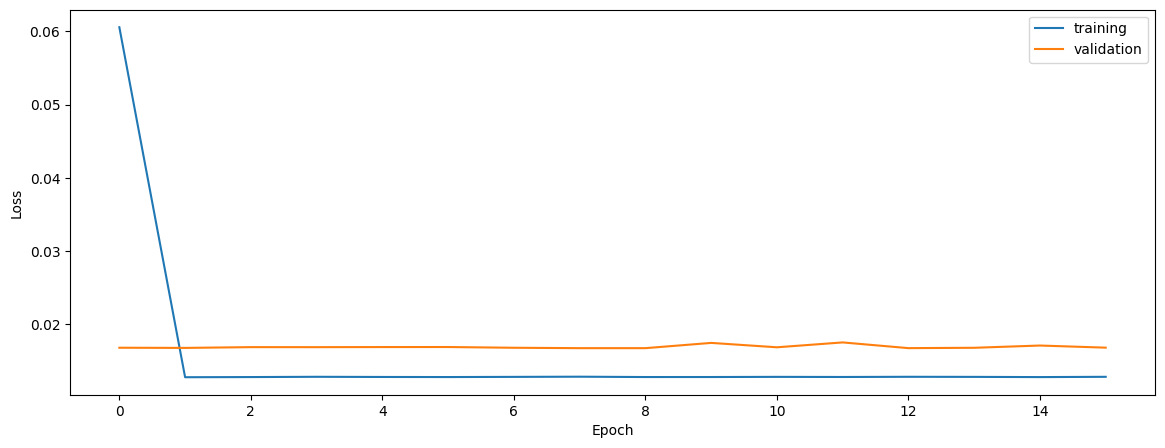

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
nan
nan
nan


/ZFS/public/subjects/UPC/documents/semester 3/MT/MasterThesis/source/util.py:244: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(y_true, y_pred)[0]


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
nan
nan
nan


/ZFS/public/subjects/UPC/documents/semester 3/MT/MasterThesis/source/util.py:252: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(y_true, y_pred)[0]


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
nan
nan
nan


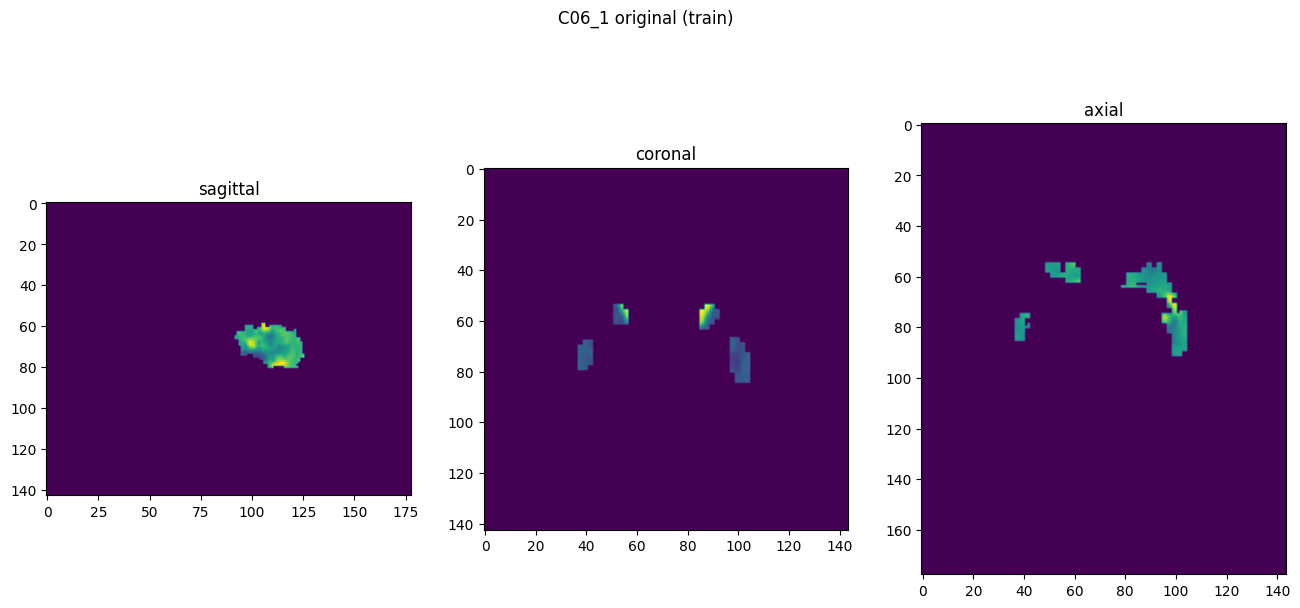

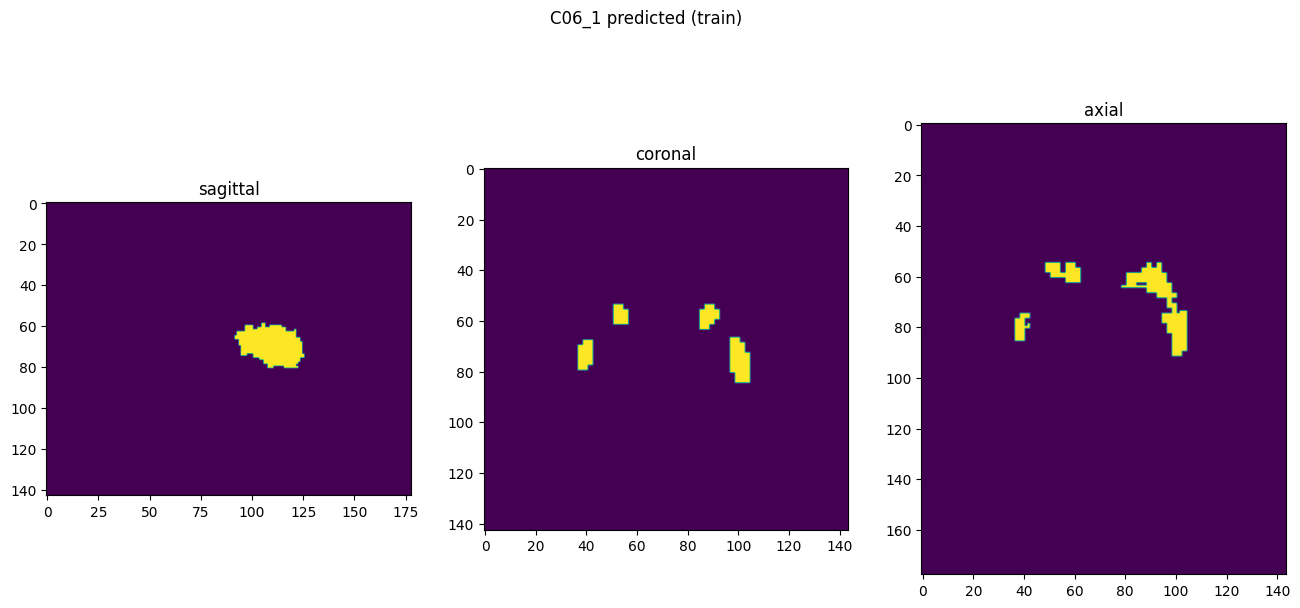

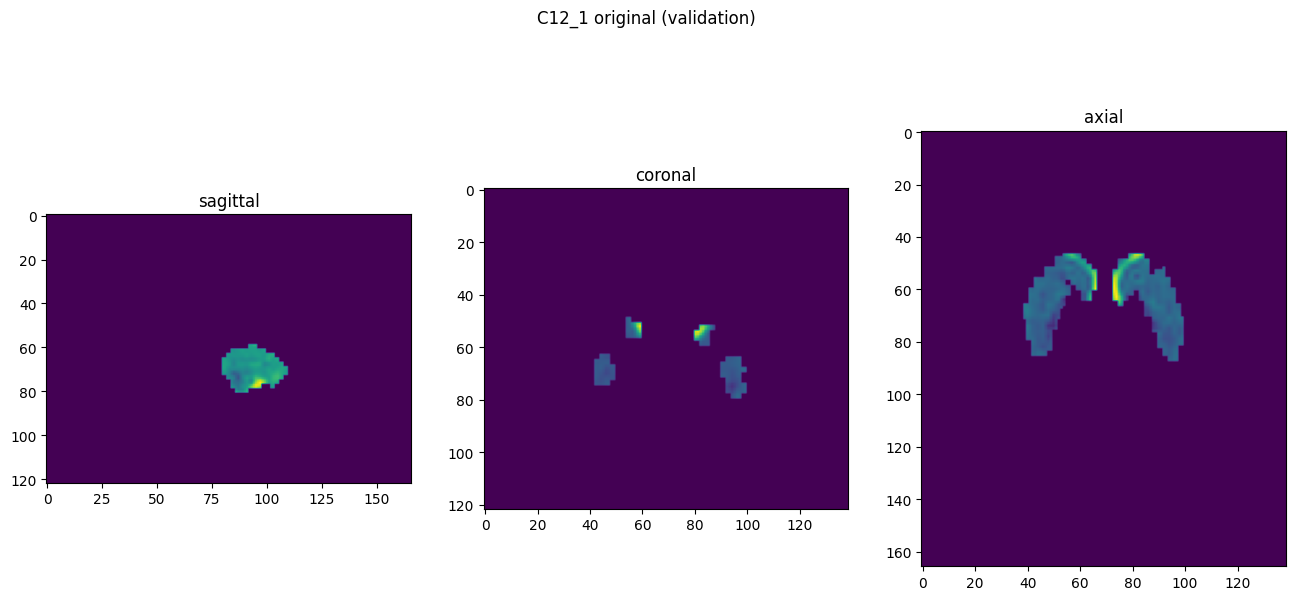

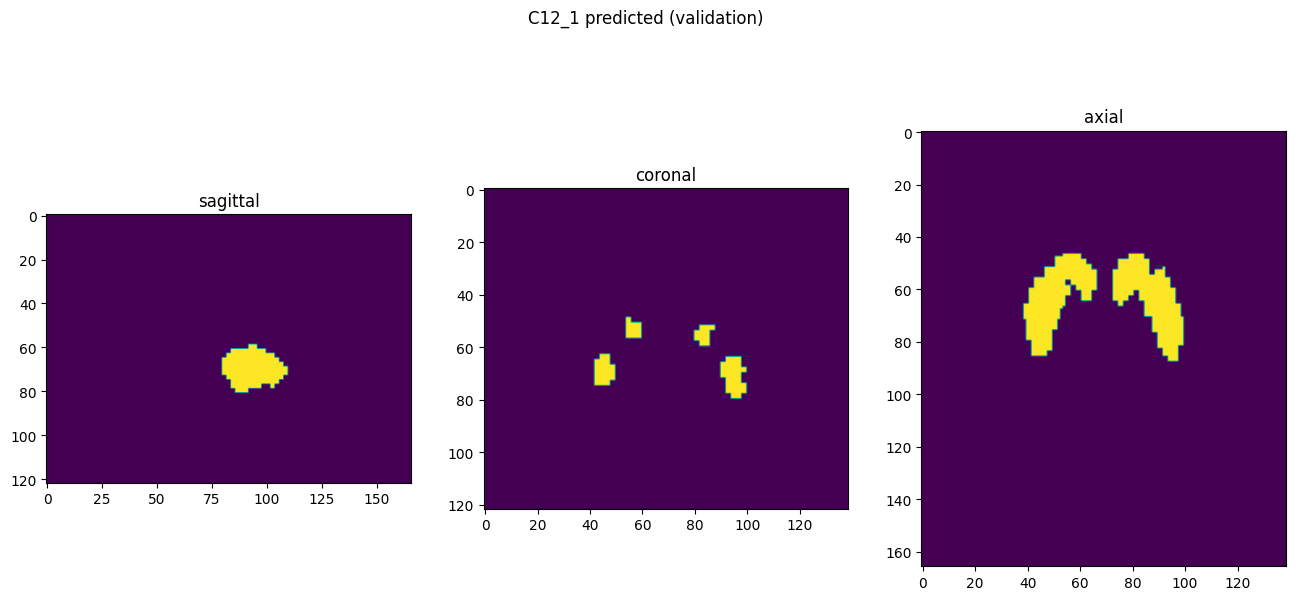

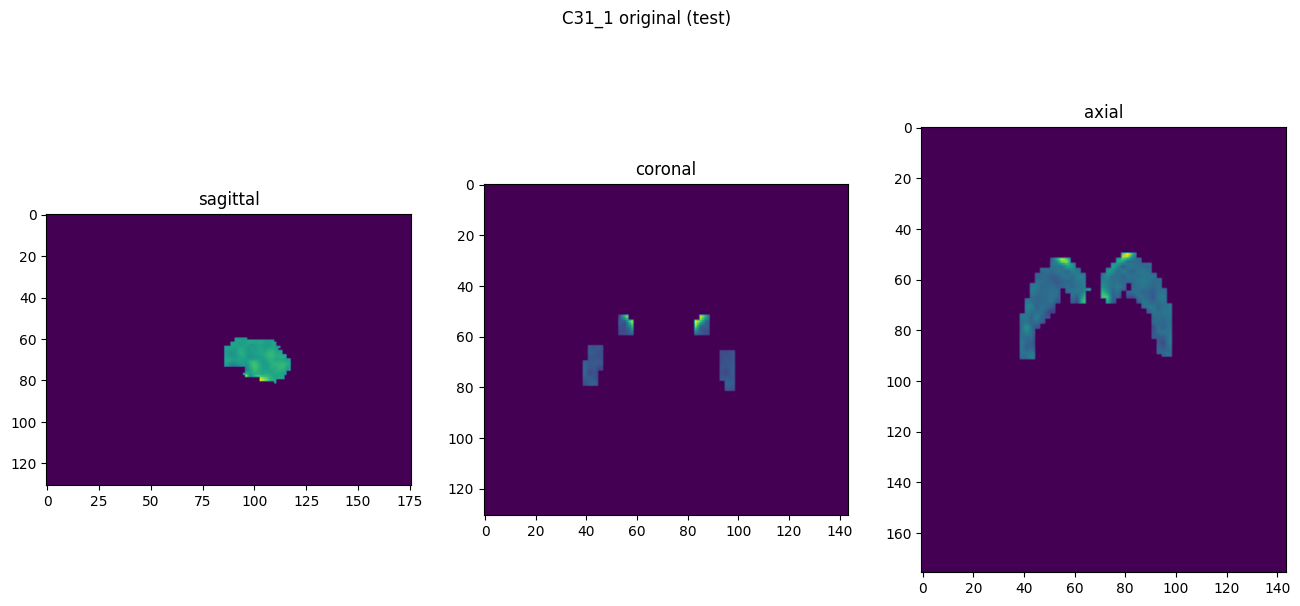

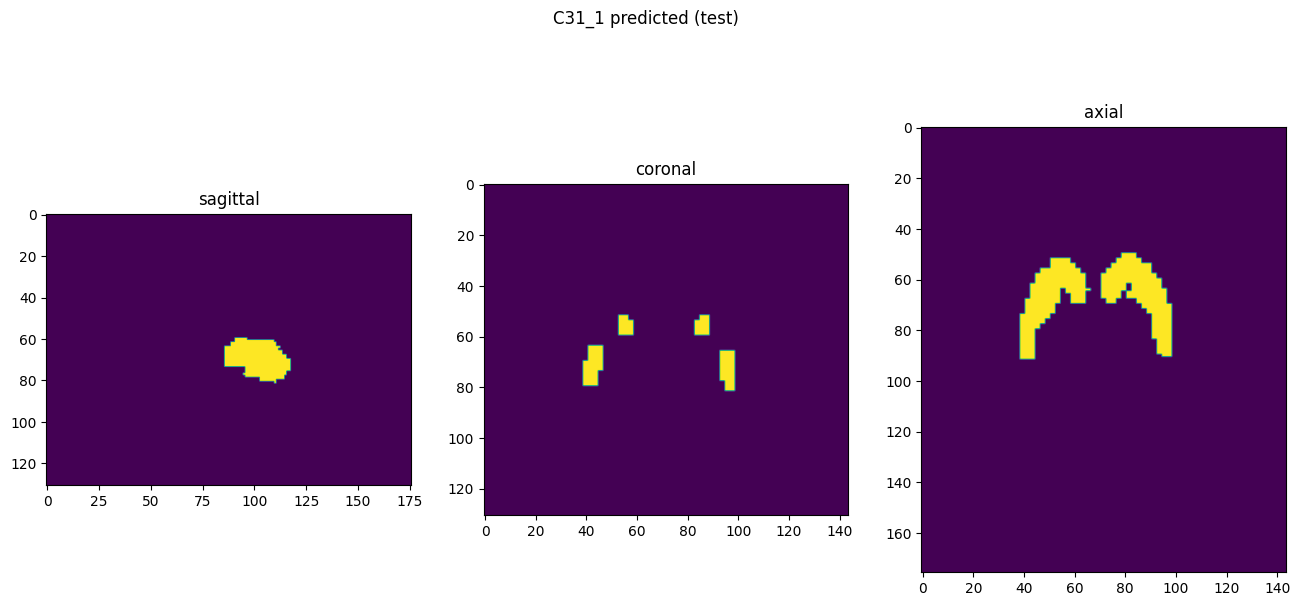

In [10]:
showResults(model, gen, threshold=None, background=False)